In [2]:
!pip install umap-learn

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score, adjusted_rand_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import umap
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

Mounted at /content/drive
TensorFlow version: 2.19.0


In [4]:
import math
import numpy as np

# CELL 3: Prepare Spectrogram Data for CNN
# This cell handles reshaping and normalizing spectrogram data for use in a Convolutional Neural Network.

# Reshape spectrogram for convolutional layers.
# The expected input format for a CNN typically includes a channel dimension.
# Assuming spectrogram_data is either 2D (n_samples, feature_length) or 3D (n_samples, time_steps, freq_bins).

print("\nOriginal spectrogram shape:", spectrogram_data.shape)

# Initialize reshaped data with the original spectrogram in case no reshaping is needed.
spec_data_reshaped = spectrogram_data

# Check if the spectrogram data is 2D and needs reshaping to 3D + channel.
if len(spectrogram_data.shape) == 2:
    n_samples, feature_length = spectrogram_data.shape

    # Attempt to infer time_steps and freq_bins for reshaping.
    # This assumes the feature_length is a product of time_steps and freq_bins.
    # A common scenario is feature_length = 128 * 128 or 128 * some_other_dim.

    # Try a square-ish reshape if possible.
    sqrt_dim = int(math.sqrt(feature_length))

    if sqrt_dim * sqrt_dim == feature_length:
        # If feature_length is a perfect square, assume square dimensions.
        time_steps = freq_bins = sqrt_dim
    else:
        # Otherwise, default to common mel-spectrogram dimensions if a standard frequency bin count (e.g., 128)
        # can divide the feature_length evenly.
        default_freq_bins = 128 # Common for Mel-spectrograms
        if feature_length % default_freq_bins == 0:
            freq_bins = default_freq_bins
            time_steps = feature_length // freq_bins
        else:
            # Fallback if inference is difficult; using the original logic's default if not perfectly divisible.
            freq_bins = 128
            time_steps = feature_length // freq_bins

    # Reshape to (n_samples, time_steps, freq_bins, 1) for CNN input.
    spec_data_reshaped = spectrogram_data.reshape(n_samples, time_steps, freq_bins, 1)
elif len(spectrogram_data.shape) == 3:
    # If already 3D (n_samples, time_steps, freq_bins), add a channel dimension.
    spec_data_reshaped = np.expand_dims(spectrogram_data, axis=-1)

# Ensure the final shape has 4 dimensions (batch, height, width, channels).
if len(spec_data_reshaped.shape) != 4:
    print(f"Warning: Spectrogram data shape after processing is {spec_data_reshaped.shape}, expected 4D for CNN input.")

print(f"Reshaped spectrogram shape for CNN: {spec_data_reshaped.shape}")

# Normalize spectrogram data to the [0, 1] range.
# This is crucial for models using sigmoid activation in the output layer or binary crossentropy loss.
# It also helps with model stability and training performance.
# Assumes spectrogram values represent non-negative intensities.
min_intensity = np.min(spec_data_reshaped)
max_intensity = np.max(spec_data_reshaped)

# Add a small epsilon to the denominator to prevent division by zero if all values are the same.
spec_data_normalized = (spec_data_reshaped - min_intensity) / (max_intensity - min_intensity + 1e-8)

print(f"Spectrogram data normalized. Min: {np.min(spec_data_normalized):.4f}, Max: {np.max(spec_data_normalized):.4f}")



Original spectrogram shape: (683, 128, 256)
Reshaped spectrogram shape for CNN: (683, 128, 256, 1)
Spectrogram data normalized. Min: 0.0000, Max: 1.0000


In [3]:
# ========================================
# CELL 2: Load and Explore Data

# Load your files
dataset = pd.read_csv('/content/drive/MyDrive/VAE for Hybrid Language Music Clustering/Dataset/dataset.csv')
preprocessed_data = np.load('/content/drive/MyDrive/VAE for Hybrid Language Music Clustering/Dataset/processed_ids.npy')
spectrogram_data = np.load('/content/drive/MyDrive/VAE for Hybrid Language Music Clustering/Dataset/processed_spectrograms.npy')

print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)
print(f"Dataset shape: {dataset.shape}")
print(f"Preprocessed data shape: {preprocessed_data.shape}")
print(f"Spectrogram shape: {spectrogram_data.shape}")
print(f"\nDataset columns: {dataset.columns.tolist()}")
print(f"\nFirst few rows:")
print(dataset.head())
# Check if there are labels for ARI calculation
has_labels = 'label' in dataset.columns or 'genre' in dataset.columns or 'language' in dataset.columns
if has_labels:
    label_col = 'label' if 'label' in dataset.columns else ('genre' if 'genre' in dataset.columns else 'language')
    true_labels = dataset[label_col].values
    print(f"\nFound labels in column: {label_col}")
    print(f"Unique labels: {np.unique(true_labels)}")
else:
    true_labels = None
    print("\nNo labels found. ARI will not be computed.")

DATA OVERVIEW
Dataset shape: (796, 5)
Preprocessed data shape: (683,)
Spectrogram shape: (683, 128, 256)

Dataset columns: ['id', 'title', 'audio_path', 'genre', 'lyrics']

First few rows:
       id                    title  \
0  711734    Yall Come Back Saloon   
1   82203                Beers Ago   
2  445332               Have Mercy   
3  541844  Memphis in the Meantime   
4  228626       Good Hearted Woman   

                                          audio_path    genre  \
0  data/audio/Y'all Come Back Saloon [Hmae3bOX_X0...  country   
1             data/audio/Beers Ago [Hosifr6ycwU].wav  country   
2  data/audio/What a Friend We Have in Jesus [ttN...  country   
3  data/audio/Memphis In The Meantime [KxhE-2apva...  country   
4  data/audio/A Good Hearted Woman (Live at Weste...  country   

                                              lyrics  
0  She played tambourine with a silver jingle\nAn...  
1  [Verse 1]\nI had a hand-me-down ride painted r...  
2  Have mercy on me, baby\

In [10]:
# ========================================
# CELL 9: Build Hybrid VAE (Audio + Lyrics)
# ========================================

print("\n" + "=" * 60)
print("BUILDING HYBRID VAE (AUDIO + LYRICS)")
print("=" * 60)

# --- 1. Prepare Lyrics Input Branch ---
# This branch processes the normalized lyrics embeddings.
lyrics_dim = lyrics_embeddings_normalized.shape[1] # Determine input dimension from preprocessed lyrics
lyrics_input = keras.Input(shape=(lyrics_dim,), name='lyrics_input')

# Lyrics encoder sub-network (Dense layers)
# Extracts features from lyrics embeddings into a lower-dimensional space.
lyrics_x = layers.Dense(256, activation='relu', name='lyrics_dense1')(lyrics_input)
lyrics_x = layers.Dropout(0.3, name='lyrics_dropout1')(lyrics_x) # Dropout for regularization
lyrics_x = layers.Dense(128, activation='relu', name='lyrics_dense2')(lyrics_x)
lyrics_encoded = layers.Dense(32, activation='relu', name='lyrics_encoded')(lyrics_x)

# --- 2. Integrate Spectrogram Encoder ---
# The pre-trained convolutional encoder (conv_encoder) is used to process spectrograms.
# This reuses the learned audio representations.
spec_input = keras.Input(shape=input_shape, name='spec_input')

# Pass spectrogram input through the existing conv_encoder.
# We only need the sampled latent vector (z_s) for concatenation here.
z_mean_s, z_log_var_s, z_s = conv_encoder(spec_input)

# --- 3. Fuse Modalities ---
# Concatenate the latent representations from both audio (spectrogram) and lyrics.
combined = layers.Concatenate(name='combined_features')([z_s, lyrics_encoded])

# Fusion layer to process the combined features.
fusion = layers.Dense(128, activation='relu', name='fusion_dense1')(combined)
fusion = layers.Dropout(0.3, name='fusion_dropout1')(fusion)

# --- 4. Hybrid Latent Space ---
# Define the hybrid latent space, similar to a standard VAE.
# This latent space combines information from both modalities.
hybrid_z_mean = layers.Dense(latent_dim, name='hybrid_z_mean')(fusion)
hybrid_z_log_var = layers.Dense(latent_dim, name='hybrid_z_log_var')(fusion)

# Sample from the hybrid latent distribution using the reparameterization trick.
hybrid_z = Sampling(name='hybrid_z_sampling')([hybrid_z_mean, hybrid_z_log_var])

# --- 5. Hybrid Encoder Model ---
# The hybrid encoder takes both spectrogram and lyrics as input
# and outputs the parameters of the hybrid latent space.
hybrid_encoder = Model(inputs=[spec_input, lyrics_input],
                       outputs=[hybrid_z_mean, hybrid_z_log_var, hybrid_z],
                       name='hybrid_encoder')
hybrid_encoder.summary()

# --- 6. Hybrid Decoder Model ---
# The hybrid decoder takes a sample from the hybrid latent space
# and reconstructs both the spectrogram and the lyrics embeddings.
hybrid_latent_input = keras.Input(shape=(latent_dim,), name='hybrid_latent_input')

# Reconstruct spectrogram using the pre-trained convolutional decoder.
spec_decoded = conv_decoder(hybrid_latent_input)

# Decode back to lyrics embeddings using a separate sub-network.
lyrics_decoder_x = layers.Dense(128, activation='relu', name='lyrics_decode_dense1')(hybrid_latent_input)
lyrics_decoder_x = layers.Dense(256, activation='relu', name='lyrics_decode_dense2')(lyrics_decoder_x)
lyrics_decoded = layers.Dense(lyrics_dim, activation='sigmoid', name='lyrics_decoded')(lyrics_decoder_x)

hybrid_decoder = Model(inputs=hybrid_latent_input, outputs=[spec_decoded, lyrics_decoded], name='hybrid_decoder')
hybrid_decoder.summary()

# --- 7. Custom Hybrid VAE Class ---
# This custom Keras Model encapsulates the hybrid encoder and decoder,
# and defines the VAE's loss function for both modalities plus KL divergence.
class HybridVAE(keras.Model):
    """Hybrid Variational Autoencoder (VAE) model for audio and text modalities."""

    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Initialize metrics to track losses for each modality and the total loss.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_spec_loss_tracker = keras.metrics.Mean(name="reconstruction_spec_loss")
        self.reconstruction_lyrics_loss_tracker = keras.metrics.Mean(name="reconstruction_lyrics_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        """Forward pass through the Hybrid VAE. (Note: Loss calculated in train_step)"""
        # Inputs are expected to be a list: [spectrogram_data, lyrics_data]
        spectrogram_data, lyrics_data = inputs

        # Encode both modalities to get latent space parameters and sample.
        z_mean, z_log_var, z = self.encoder([spectrogram_data, lyrics_data])
        # Decode the sampled latent vector to reconstruct both modalities.
        spec_reconstruction, lyrics_reconstruction = self.decoder(z)
        return spec_reconstruction, lyrics_reconstruction

    @property
    def metrics(self):
        """Returns the list of metrics monitored during training/testing."""
        return [
            self.total_loss_tracker,
            self.reconstruction_spec_loss_tracker,
            self.reconstruction_lyrics_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """Performs a single training step for the Hybrid VAE."""
        # 'data' is expected to be a tuple: ([spectrogram_inputs, lyrics_inputs], [spectrogram_targets, lyrics_targets])
        # where inputs and targets are typically the same for VAEs.
        input_data, target_data = data
        spec_data_batch, lyrics_data_batch = input_data
        spec_target_batch, lyrics_target_batch = target_data

        with tf.GradientTape() as tape:
            # Encode the combined input data.
            z_mean, z_log_var, z = self.encoder([spec_data_batch, lyrics_data_batch])
            # Decode the sampled latent vector to get reconstructions of both modalities.
            spec_reconstruction, lyrics_reconstruction = self.decoder(z)

            # Calculate Reconstruction Loss for Spectrograms.
            # Uses binary_crossentropy as spectrograms were normalized to [0,1].
            spec_recon_loss = keras.ops.mean(
                keras.ops.sum(
                    keras.losses.binary_crossentropy(spec_target_batch, spec_reconstruction),
                    axis=(1, 2) # Sum across spatial dimensions (height, width) for each sample
                ) # No reduction at batch level yet
            )
            # Calculate Reconstruction Loss for Lyrics Embeddings.
            # Uses Mean Squared Error (MSE) as lyrics embeddings are continuous values.
            lyrics_recon_loss = keras.ops.mean(
                keras.losses.mse(lyrics_target_batch, lyrics_reconstruction)
            )

            # Calculate KL Divergence Loss.
            # Encourages the hybrid latent distribution to be close to a standard normal distribution.
            kl_loss = -0.5 * keras.ops.mean(
                keras.ops.sum(
                    1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                    axis=1 # Sum across latent dimensions
                )
            )

            # Total Hybrid VAE loss is the sum of reconstruction losses and KL divergence loss.
            total_loss = spec_recon_loss + lyrics_recon_loss + kl_loss

        # Compute gradients and apply them to update model weights.
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the state of the loss metrics.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_spec_loss_tracker.update_state(spec_recon_loss)
        self.reconstruction_lyrics_loss_tracker.update_state(lyrics_recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Return current metric values.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_spec_loss": self.reconstruction_spec_loss_tracker.result(),
            "reconstruction_lyrics_loss": self.reconstruction_lyrics_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Performs a single test/validation step for the Hybrid VAE."""
        # 'data' is expected to be a tuple: ([spectrogram_inputs, lyrics_inputs], [spectrogram_targets, lyrics_targets])
        input_data, target_data = data
        spec_data_batch, lyrics_data_batch = input_data
        spec_target_batch, lyrics_target_batch = target_data

        # Encode the combined input data.
        z_mean, z_log_var, z = self.encoder([spec_data_batch, lyrics_data_batch])
        # Decode the sampled latent vector to get reconstructions of both modalities.
        spec_reconstruction, lyrics_reconstruction = self.decoder(z)

        # Calculate Reconstruction Loss for Spectrograms.
        spec_recon_loss = keras.ops.mean(
            keras.ops.sum(
                keras.losses.binary_crossentropy(spec_target_batch, spec_reconstruction),
                axis=(1, 2)
            )
        )
        # Calculate Reconstruction Loss for Lyrics Embeddings.
        lyrics_recon_loss = keras.ops.mean(
            keras.losses.mse(lyrics_target_batch, lyrics_reconstruction)
        )

        # Calculate KL Divergence Loss.
        kl_loss = -0.5 * keras.ops.mean(
            keras.ops.sum(
                1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                axis=1
            )
        )

        # Total Hybrid VAE loss.
        total_loss = spec_recon_loss + lyrics_recon_loss + kl_loss

        # Update the state of the loss metrics.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_spec_loss_tracker.update_state(spec_recon_loss)
        self.reconstruction_lyrics_loss_tracker.update_state(lyrics_recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Return current metric values.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_spec_loss": self.reconstruction_spec_loss_tracker.result(),
            "reconstruction_lyrics_loss": self.reconstruction_lyrics_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



BUILDING HYBRID VAE (AUDIO + LYRICS)


Model: "hybrid_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lyrics_input        │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lyrics_dense1       │ (None, 256)       │     98,560 │ lyrics_input[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lyrics_dropout1     │ (None, 256)       │          0 │ lyrics_dense1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spec_input          │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lyrics_dense2       │ (None, 128)       │     32,896 │ lyrics_dropout1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_encoder        │ [(None, 64),      │ 17,233,152 │ spec_input[0][0]  │
│ (Functional)        │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lyrics_encoded      │ (None, 32)        │      4,128 │ lyrics_dense2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_features   │ (None, 96)        │          0 │ conv_encoder[0][… │
│ (Concatenate)       │                   │            │ lyrics_encoded[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense1       │ (None, 128)       │     12,416 │ combined_feature… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dropout1     │ (None, 128)       │          0 │ fusion_dense1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hybrid_z_mean       │ (None, 64)        │      8,256 │ fusion_dropout1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hybrid_z_log_var    │ (None, 64)        │      8,256 │ fusion_dropout1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hybrid_z_sampling   │ (None, 64)        │          0 │ hybrid_z_mean[0]… │
│ (Sampling)          │                   │            │ hybrid_z_log_var… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,397,664 (66.37 MB)

 Trainable params: 17,396,704 (66.36 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "hybrid_decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ hybrid_latent_input │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lyrics_decode_dens… │ (None, 128)       │      8,320 │ hybrid_latent_in… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lyrics_decode_dens… │ (None, 256)       │     33,024 │ lyrics_decode_de… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_decoder        │ (None, 128, 256,  │ 17,822,849 │ hybrid_latent_in… │
│ (Functional)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lyrics_decoded      │ (None, 384)       │     98,688 │ lyrics_decode_de… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,962,881 (68.52 MB)

 Trainable params: 17,961,921 (68.52 MB)

 Non-trainable params: 960 (3.75 KB)

In [5]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

# ========================================
# CELL 4: Prepare Lyrics Embeddings (if available)
# ========================================

# Define the base path for data files. This path is crucial for locating various assets.
# This variable should be set in a preceding cell or globally for the notebook.
data_path = '/content/drive/MyDrive/VAE for Hybrid Language Music Clustering'

# Construct the full file path for the lyrics embeddings.
# Corrected file name based on directory listing.
lyrics_embedding_file_path = os.path.join(data_path, '/content/drive/MyDrive/VAE for Hybrid Language Music Clustering/Dataset/Copy of lyrics_embeddings.npy')

# Initialize flags and variables.
# `use_lyrics_embeddings_feature` indicates if a lyrics-based feature will be incorporated.
# `lyrics_embeddings_normalized` will store the processed lyrics features.
use_lyrics_embeddings_feature = False
lyrics_embeddings_normalized = None

# --- Attempt to Load Existing Lyrics Embeddings ---
if os.path.exists(lyrics_embedding_file_path):
    print(f"\n--- Loading Lyrics Embeddings ---")
    print(f"Found lyrics embeddings file at: {lyrics_embedding_file_path}")

    # Load the pre-computed embeddings.
    lyrics_embeddings = np.load(lyrics_embedding_file_path)
    print(f"Original lyrics embeddings shape: {lyrics_embeddings.shape}")

    # Normalize the embeddings using StandardScaler.
    # Normalization (mean=0, std=1) helps ensure features contribute equally to the model
    # and can improve convergence during training.
    scaler = StandardScaler()
    lyrics_embeddings_normalized = scaler.fit_transform(lyrics_embeddings)

    use_lyrics_embeddings_feature = True
    print("Lyrics embeddings loaded and normalized successfully.")
    print(f"Normalized lyrics embeddings shape: {lyrics_embeddings_normalized.shape}")

# --- Create Dummy Embeddings if File Not Found ---
else:
    print(f"\n--- Generating Dummy Lyrics Embeddings ---")
    print(f"No lyrics embeddings file found at: {lyrics_embedding_file_path}.")
    print("Creating dummy lyrics embeddings as a fallback. This is a placeholder for actual NLP features.")

    # `preprocessed_data` is assumed to be an array of preprocessed IDs (1D).
    # If `preprocessed_data` were a 2D array of features, we might try to extract from it.
    # However, since it's 1D, we generate a simple placeholder.

    # Determine the number of samples from `preprocessed_data`.
    num_samples = preprocessed_data.shape[0]

    # Create a 2D array of zeros. Each sample will have one dummy feature.
    # In a real scenario, this would be replaced by actual NLP-derived features from lyrics text.
    dummy_embeddings_input = np.zeros((num_samples, 1))
    print(f"Created a dummy input array of shape: {dummy_embeddings_input.shape} (all zeros).")

    # Normalize these dummy embeddings. Even dummy features should be scaled for consistency.
    scaler = StandardScaler()
    lyrics_embeddings_normalized = scaler.fit_transform(dummy_embeddings_input)

    use_lyrics_embeddings_feature = True # A lyrics feature (even if dummy) is now prepared.
    print(f"Dummy lyrics embeddings created and normalized. Shape: {lyrics_embeddings_normalized.shape}")

# --- Final Status Report ---
print(f"\n--- Lyrics Embeddings Preparation Complete ---")
print(f"A lyrics embeddings feature will be used in the model: {use_lyrics_embeddings_feature}")
print(f"Shape of final lyrics embeddings feature: {lyrics_embeddings_normalized.shape if lyrics_embeddings_normalized is not None else 'Not available'}")



--- Loading Lyrics Embeddings ---
Found lyrics embeddings file at: /content/drive/MyDrive/VAE for Hybrid Language Music Clustering/Dataset/Copy of lyrics_embeddings.npy
Original lyrics embeddings shape: (683, 384)
Lyrics embeddings loaded and normalized successfully.
Normalized lyrics embeddings shape: (683, 384)

--- Lyrics Embeddings Preparation Complete ---
A lyrics embeddings feature will be used in the model: True
Shape of final lyrics embeddings feature: (683, 384)


In [11]:
import os

data_path = '/content/drive/MyDrive/VAE for Hybrid Language Music Clustering'
lyrics_embedding_file_path = os.path.join(data_path, '/content/drive/MyDrive/VAE for Hybrid Language Music Clustering/Dataset/Copy of lyrics_embeddings.npy')

print(f"Checking for file: {lyrics_embedding_file_path}")
if os.path.exists(lyrics_embedding_file_path):
    print("SUCCESS: lyrics_embeddings.npy found at the specified path!")
else:
    print("FAILURE: lyrics_embeddings.npy NOT found at the specified path.")
    print("\nListing contents of the directory:")
    try:
        for item in os.listdir(data_path):
            print(f"- {item}")
    except FileNotFoundError:
        print(f"Error: The directory {data_path} was not found. Please ensure your Google Drive is mounted correctly and the path is valid.")
    except Exception as e:
        print(f"An error occurred while listing directory contents: {e}")


Checking for file: /content/drive/MyDrive/VAE for Hybrid Language Music Clustering/Dataset/Copy of lyrics_embeddings.npy
SUCCESS: lyrics_embeddings.npy found at the specified path!


In [6]:
# ========================================
# CELL 5: Build Convolutional VAE for Spectrograms
# ========================================

# Define the dimensionality of the latent space.
# This is a hyperparameter that determines the complexity of the learned representation.
latent_dim = 64

# --- Sampling Layer ---
# This custom layer implements the reparameterization trick,
# which allows for backpropagation through the sampling process.
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        # Get batch size and dimensionality of the latent space.
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Generate random normal epsilon for reparameterization.
        epsilon = tf.random.normal(shape=(batch, dim))
        # z = z_mean + exp(0.5 * z_log_var) * epsilon
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- Encoder Model ---
# The encoder takes the input spectrogram and maps it to the parameters
# (mean and log-variance) of the latent space distribution.

# Dynamically determine input shape from preprocessed spectrogram data.
# Assumes spec_data_normalized is already available and has shape (batch, height, width, channels).
input_shape = spec_data_normalized.shape[1:]  # Exclude batch dimension
print(f"\nBuilding Conv-VAE with input shape: {input_shape}")

encoder_inputs = keras.Input(shape=input_shape, name='encoder_input')

# Apply convolutional layers to extract features.
# Each Conv2D layer is followed by BatchNormalization to stabilize training.
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same', name='enc_conv1')(encoder_inputs)
x = layers.BatchNormalization(name='enc_bn1')(x)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same', name='enc_conv2')(x)
x = layers.BatchNormalization(name='enc_bn2')(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same', name='enc_conv3')(x)
x = layers.BatchNormalization(name='enc_bn3')(x)
x = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same', name='enc_conv4')(x)
x = layers.BatchNormalization(name='enc_bn4')(x)

# Store the shape before flattening to reconstruct it later in the decoder.
shape_before_flattening = x.shape[1:]

# Flatten the feature maps and apply a dense layer.
x = layers.Flatten(name='enc_flatten')(x)
x = layers.Dense(512, activation='relu', name='enc_dense')(x)

# Project to the latent space's mean and log-variance.
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sample from the latent distribution using the reparameterization trick.
z = Sampling(name='z_sampling')([z_mean, z_log_var]) # Sampled latent vector

# Create the encoder model.
conv_encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='conv_encoder')
conv_encoder.summary()

# --- Decoder Model ---
# The decoder takes a sampled latent vector and reconstructs the spectrogram.

latent_inputs = keras.Input(shape=(latent_dim,), name='latent_input')

# Apply dense layers to expand the latent vector.
x = layers.Dense(512, activation='relu', name='dec_dense1')(latent_inputs)
# Reshape to the spatial dimensions needed for deconvolutional layers.
x = layers.Dense(np.prod(shape_before_flattening), activation='relu', name='dec_dense2')(x)
x = layers.Reshape(shape_before_flattening, name='dec_reshape')(x)

# Apply deconvolutional (Conv2DTranspose) layers to upsample and reconstruct.
# Each Conv2DTranspose is followed by BatchNormalization.
x = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same', name='dec_conv_transpose1')(x)
x = layers.BatchNormalization(name='dec_bn1')(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same', name='dec_conv_transpose2')(x)
x = layers.BatchNormalization(name='dec_bn2')(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same', name='dec_conv_transpose3')(x)
x = layers.BatchNormalization(name='dec_bn3')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same', name='dec_conv_transpose4')(x)
x = layers.BatchNormalization(name='dec_bn4')(x)

# Final layer outputs the reconstructed spectrogram with a single channel.
# Using 'sigmoid' activation to ensure output is in [0, 1] range, matching normalized input.
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same', name='decoder_output')(x)

# Create the decoder model.
conv_decoder = Model(latent_inputs, decoder_outputs, name='conv_decoder')
conv_decoder.summary()

# --- Convolutional VAE Class ---
# This custom Keras Model encapsulates the encoder and decoder,
# and defines the VAE's loss function (reconstruction loss + KL divergence).
class ConvVAE(keras.Model):
    """Convolutional Variational Autoencoder (VAE) model."""

    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Initialize metrics to track losses during training.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        """Forward pass through the VAE."""
        # Encode input to get latent space parameters and sample.
        z_mean, z_log_var, z = self.encoder(inputs)
        # Decode the sampled latent vector to reconstruct the input.
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        """Returns the list of metrics monitored during training/testing."""
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """Performs a single training step for the VAE."""
        if isinstance(data, tuple):
            data = data[0] # Handle cases where data is a (features, labels) tuple
        with tf.GradientTape() as tape:
            # Encode the input data.
            z_mean, z_log_var, z = self.encoder(data)
            # Decode the sampled latent vector to get reconstruction.
            reconstruction = self.decoder(z)

            # Calculate Reconstruction Loss (Binary Crossentropy).
            # Measures how well the VAE reconstructs the input.
            reconstruction_loss = keras.ops.mean(
                keras.ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2) # Sum across spatial dimensions
                )
            )
            # Calculate KL Divergence Loss.
            # Encourages the latent distribution to be close to a standard normal distribution.
            kl_loss = -0.5 * keras.ops.mean(
                keras.ops.sum(
                    1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                    axis=1 # Sum across latent dimensions
                )
            )
            # Total VAE loss is the sum of reconstruction loss and KL divergence loss.
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients and apply them to update model weights.
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the state of the loss metrics.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Return current metric values.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Performs a single test/validation step for the VAE."""
        if isinstance(data, tuple):
            data = data[0] # Handle cases where data is a (features, labels) tuple

        # Encode and decode the input data.
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Calculate Reconstruction Loss.
        reconstruction_loss = keras.ops.mean(
            keras.ops.sum(
                keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2)
            )
        )
        # Calculate KL Divergence Loss.
        kl_loss = -0.5 * keras.ops.mean(
            keras.ops.sum(
                1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                axis=1
            )
        )
        # Total VAE loss.
        total_loss = reconstruction_loss + kl_loss

        # Update the state of the loss metrics.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Return current metric values.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



Building Conv-VAE with input shape: (128, 256, 1)


Model: "conv_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv1 (Conv2D)  │ (None, 64, 128,   │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bn1             │ (None, 64, 128,   │        128 │ enc_conv1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv2 (Conv2D)  │ (None, 32, 64,    │     18,496 │ enc_bn1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bn2             │ (None, 32, 64,    │        256 │ enc_conv2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv3 (Conv2D)  │ (None, 16, 32,    │     73,856 │ enc_bn2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bn3             │ (None, 16, 32,    │        512 │ enc_conv3[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv4 (Conv2D)  │ (None, 8, 16,     │    295,168 │ enc_bn3[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bn4             │ (None, 8, 16,     │      1,024 │ enc_conv4[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_flatten         │ (None, 32768)     │          0 │ enc_bn4[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_dense (Dense)   │ (None, 512)       │ 16,777,728 │ enc_flatten[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     32,832 │ enc_dense[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     32,832 │ enc_dense[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_sampling          │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,233,152 (65.74 MB)

 Trainable params: 17,232,192 (65.74 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "conv_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense1 (Dense)              │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense2 (Dense)              │ (None, 32768)          │    16,809,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_reshape (Reshape)           │ (None, 8, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv_transpose1             │ (None, 16, 32, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn1 (BatchNormalization)    │ (None, 16, 32, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv_transpose2             │ (None, 32, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn2 (BatchNormalization)    │ (None, 32, 64, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv_transpose3             │ (None, 64, 128, 64)    │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn3 (BatchNormalization)    │ (None, 64, 128, 64)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv_transpose4             │ (None, 128, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn4 (BatchNormalization)    │ (None, 128, 256, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 128, 256, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,822,849 (67.99 MB)

 Trainable params: 17,821,889 (67.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
import math
import numpy as np

# CELL 3: Prepare Spectrogram Data for CNN
# This cell handles reshaping and normalizing spectrogram data for use in a Convolutional Neural Network.

# Reshape spectrogram for convolutional layers.
# The expected input format for a CNN typically includes a channel dimension.
# Assuming spectrogram_data is either 2D (n_samples, feature_length) or 3D (n_samples, time_steps, freq_bins).

print("\nOriginal spectrogram shape:", spectrogram_data.shape)

# Initialize reshaped data with the original spectrogram in case no reshaping is needed.
spec_data_reshaped = spectrogram_data

# Check if the spectrogram data is 2D and needs reshaping to 3D + channel.
if len(spectrogram_data.shape) == 2:
    n_samples, feature_length = spectrogram_data.shape

    # Attempt to infer time_steps and freq_bins for reshaping.
    # This assumes the feature_length is a product of time_steps and freq_bins.
    # A common scenario is feature_length = 128 * 128 or 128 * some_other_dim.

    # Try a square-ish reshape if possible.
    sqrt_dim = int(math.sqrt(feature_length))

    if sqrt_dim * sqrt_dim == feature_length:
        # If feature_length is a perfect square, assume square dimensions.
        time_steps = freq_bins = sqrt_dim
    else:
        # Otherwise, default to common mel-spectrogram dimensions if a standard frequency bin count (e.g., 128)
        # can divide the feature_length evenly.
        default_freq_bins = 128 # Common for Mel-spectrograms
        if feature_length % default_freq_bins == 0:
            freq_bins = default_freq_bins
            time_steps = feature_length // freq_bins
        else:
            # Fallback if inference is difficult; using the original logic's default if not perfectly divisible.
            freq_bins = 128
            time_steps = feature_length // freq_bins

    # Reshape to (n_samples, time_steps, freq_bins, 1) for CNN input.
    spec_data_reshaped = spectrogram_data.reshape(n_samples, time_steps, freq_bins, 1)
elif len(spectrogram_data.shape) == 3:
    # If already 3D (n_samples, time_steps, freq_bins), add a channel dimension.
    spec_data_reshaped = np.expand_dims(spectrogram_data, axis=-1)

# Ensure the final shape has 4 dimensions (batch, height, width, channels).
if len(spec_data_reshaped.shape) != 4:
    print(f"Warning: Spectrogram data shape after processing is {spec_data_reshaped.shape}, expected 4D for CNN input.")

print(f"Reshaped spectrogram shape for CNN: {spec_data_reshaped.shape}")

# Normalize spectrogram data to the [0, 1] range.
# This is crucial for models using sigmoid activation in the output layer or binary crossentropy loss.
# It also helps with model stability and training performance.
# Assumes spectrogram values represent non-negative intensities.
min_intensity = np.min(spec_data_reshaped)
max_intensity = np.max(spec_data_reshaped)

# Add a small epsilon to the denominator to prevent division by zero if all values are the same.
spec_data_normalized = (spec_data_reshaped - min_intensity) / (max_intensity - min_intensity + 1e-8)

print(f"Spectrogram data normalized. Min: {np.min(spec_data_normalized):.4f}, Max: {np.max(spec_data_normalized):.4f}")


Original spectrogram shape: (683, 128, 256)
Reshaped spectrogram shape for CNN: (683, 128, 256, 1)
Spectrogram data normalized. Min: 0.0000, Max: 1.0000


In [7]:
# ========================================
# CELL 6: Conv-VAE Loss and Compilation
# ========================================

# Instantiate the ConvVAE model
# This creates an instance of our custom VAE class, combining the encoder and decoder.
conv_vae = ConvVAE(encoder=conv_encoder, decoder=conv_decoder)

# Compile the model.
# For the ConvVAE, the custom loss functions (reconstruction loss + KL divergence)
# are calculated internally within the overridden `train_step` and `test_step` methods.
# Therefore, we only need to specify an optimizer here.
# Adam optimizer is chosen with a small learning rate for stable training.
conv_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("\nConv-VAE Model Summary:")
# To display a summary of the entire VAE model, it needs to be built first.
# The `build` method expects the input shape (excluding the batch dimension).
# `input_shape` was already determined dynamically in CELL 5 from `spec_data_normalized`.
# (None,) + input_shape creates a shape like (None, 128, 256, 1) for the batch input.
conv_vae.build(input_shape=(None,) + input_shape)
conv_vae.summary()



Conv-VAE Model Summary:


Model: "conv_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_encoder (Functional)       │ ((None, 64), (None,    │    17,233,152 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_decoder (Functional)       │ (None, 128, 256, 1)    │    17,822,849 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,056,001 (133.73 MB)

 Trainable params: 35,054,081 (133.72 MB)

 Non-trainable params: 1,920 (7.50 KB)


TRAINING CONVOLUTIONAL VAE
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - kl_loss: 0.2658 - loss: 22698.8379 - reconstruction_loss: 22698.5723 - val_kl_loss: 12.6842 - val_loss: 22511.9609 - val_reconstruction_loss: 22499.2773
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - kl_loss: 22.0514 - loss: 22393.3379 - reconstruction_loss: 22371.2852 - val_kl_loss: 2.4621 - val_loss: 22351.9883 - val_reconstruction_loss: 22349.5254
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - kl_loss: 1.3516 - loss: 22140.7852 - reconstruction_loss: 22139.4336 - val_kl_loss: 0.5025 - val_loss: 22263.0215 - val_reconstruction_loss: 22262.5195
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - kl_loss: 0.7195 - loss: 22047.5625 - reconstruction_loss: 22046.8438 - val_kl_loss: 5.1461 - val_loss: 22279.2676 - val_reconstruction_loss: 22274.1211
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - kl_loss: 4.2520 - loss: 21950.3652 - reconstruction_loss: 21946.1133 - val_kl_loss: 8.8164 - val_l

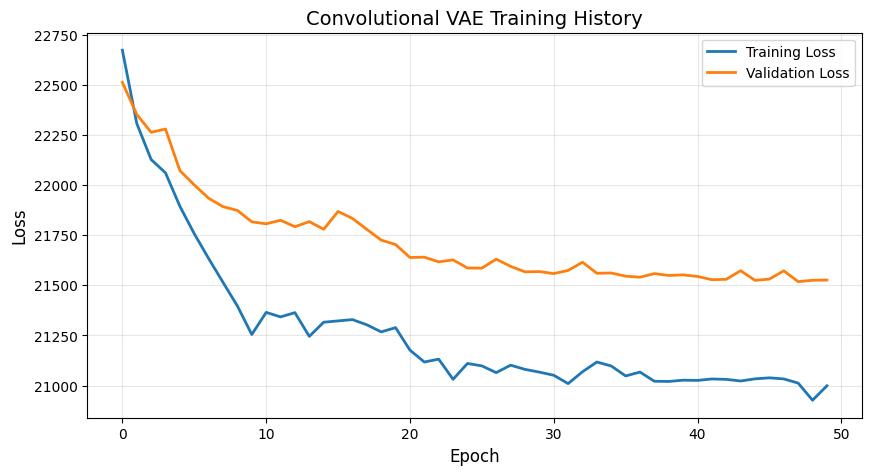

In [8]:
# ========================================
# CELL 7: Train Convolutional VAE
# ========================================

import matplotlib.pyplot as plt

print("\n" + "=" * 60)
print("TRAINING CONVOLUTIONAL VAE")
print("=" * 60)

# Define base path for saving results, assuming it's the same as data_path
# Make sure this path exists or create it if necessary
base_path = '/content/drive/MyDrive/VAE for Hybrid Language Music Clustering'

# Train the ConvVAE model.
# The input to the VAE's `fit` method is typically the same data for both features and labels
# as it learns to reconstruct its own input (unsupervised learning).
conv_history = conv_vae.fit(
    spec_data_normalized,    # Input data (spectrograms)
    spec_data_normalized,    # Target data (spectrograms for reconstruction)
    epochs=50,               # Number of times to iterate over the entire dataset
    batch_size=32,           # Number of samples per gradient update
    validation_split=0.2,    # Fraction of the training data to be used as validation data
    verbose=1                # Display progress bar during training
)

# --- Plotting Training History ---
# Visualize the training and validation loss over epochs to monitor model performance
# and identify potential overfitting or underfitting.
plt.figure(figsize=(10, 5))

# Plot training loss (total loss calculated by the custom train_step)
plt.plot(conv_history.history['loss'], label='Training Loss', linewidth=2)

# Plot validation loss
plt.plot(conv_history.history['val_loss'], label='Validation Loss', linewidth=2)

# Add labels and title for clarity
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Convolutional VAE Training History', fontsize=14)

# Add a legend to distinguish between training and validation loss
plt.legend(fontsize=10)

# Add a grid for better readability of data points
plt.grid(True, alpha=0.3)

# Ensure the results directory exists before saving
results_dir = os.path.join(base_path, 'results/visualizations')
os.makedirs(results_dir, exist_ok=True)

# Save the plot to a file
plt.savefig(os.path.join(results_dir, 'conv_vae_training.png'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [9]:
# ========================================
# CELL 8: Extract Latent Features from Conv-VAE
# ========================================

print("\n" + "=" * 60)
print("EXTRACTING LATENT FEATURES FROM CONVOLUTIONAL VAE")
print("=" * 60)

# Use the trained convolutional encoder to generate latent space representations
# for the spectrogram data. The encoder outputs z_mean, z_log_var, and z (sampled latent vector).
# We typically use z_mean as the deterministic latent feature vector for downstream tasks.

# The `predict` method of the Keras model will run the input data through the `conv_encoder`
# and return its outputs (z_mean, z_log_var, z).
z_mean_spec, z_log_var_spec, z_spec = conv_encoder.predict(
    spec_data_normalized, # Input: the normalized spectrogram data
    verbose=0             # Suppress verbose output during prediction
)

# We are primarily interested in the mean of the latent distribution (z_mean)
# as it provides a stable and representative embedding of the input spectrogram.
spectrogram_latent_features = z_mean_spec

print(f"Spectrogram latent features (z_mean) extracted. Shape: {spectrogram_latent_features.shape}")

# You can also choose to use the sampled latent vector 'z_spec' or a combination
# if your application requires stochasticity or further investigation of the latent space.
# For most clustering or classification tasks, z_mean is preferred.


EXTRACTING LATENT FEATURES FROM CONVOLUTIONAL VAE
Spectrogram latent features (z_mean) extracted. Shape: (683, 64)


In [13]:
# ========================================
# CELL 10: Hybrid VAE Compilation and Summary
# ========================================

print("\n" + "=" * 60)
print("COMPILING HYBRID VAE")
print("=" * 60)

# Instantiate the HybridVAE model
# This creates an instance of our custom HybridVAE class, bringing together
# the hybrid encoder and hybrid decoder defined in CELL 9.
hybrid_vae = HybridVAE(encoder=hybrid_encoder, decoder=hybrid_decoder)

# Compile the model.
# For the HybridVAE, the loss calculations (reconstruction losses for both
# spectrograms and lyrics, plus KL divergence) are handled internally within
# the overridden `train_step` and `test_step` methods. Therefore, we only
# need to specify an optimizer here.
# The Adam optimizer is chosen with a small learning rate for stable training.
hybrid_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("\nHybrid VAE Model Summary:")
# To display a summary of the entire Hybrid VAE model, it needs to be built first.
# The `build` method requires sample input shapes for all its inputs.
# The HybridVAE expects two inputs: spectrogram data and lyrics embeddings.
# input_shape was determined in CELL 5, and lyrics_dim in CELL 9.
hybrid_vae.build(input_shape=[(None,) + input_shape, (None, lyrics_dim)])
hybrid_vae.summary()


COMPILING HYBRID VAE

Hybrid VAE Model Summary:


Model: "hybrid_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hybrid_encoder (Functional)     │ ((None, 64), (None,    │    17,397,664 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hybrid_decoder (Functional)     │ ((None, 128, 256, 1),  │    17,962,881 │
│                                 │ (None, 384))           │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,360,545 (134.89 MB)

 Trainable params: 35,358,625 (134.88 MB)

 Non-trainable params: 1,920 (7.50 KB)


TRAINING HYBRID VAE
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - kl_loss: 38.4502 - loss: 21647.2656 - reconstruction_lyrics_loss: 1.2711 - reconstruction_spec_loss: 21607.5430 - val_kl_loss: 77.0882 - val_loss: 21875.7402 - val_reconstruction_lyrics_loss: 1.1394 - val_reconstruction_spec_loss: 21797.5137
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - kl_loss: 83.8523 - loss: 21360.3906 - reconstruction_lyrics_loss: 1.2438 - reconstruction_spec_loss: 21275.2949 - val_kl_loss: 38.7413 - val_loss: 21805.7363 - val_reconstruction_lyrics_loss: 1.1149 - val_reconstruction_spec_loss: 21765.8789
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - kl_loss: 46.0088 - loss: 21282.1289 - reconstruction_lyrics_loss: 1.2127 - reconstruction_spec_loss: 21234.9062 - val_kl_loss: 48.6825 - val_loss: 21697.2852 - val_reconstruction_lyrics_loss: 1.0783 - val_reconstruction_spec_loss: 21647.5234
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - kl_loss: 53.2140 - loss: 21196.3867 - recons

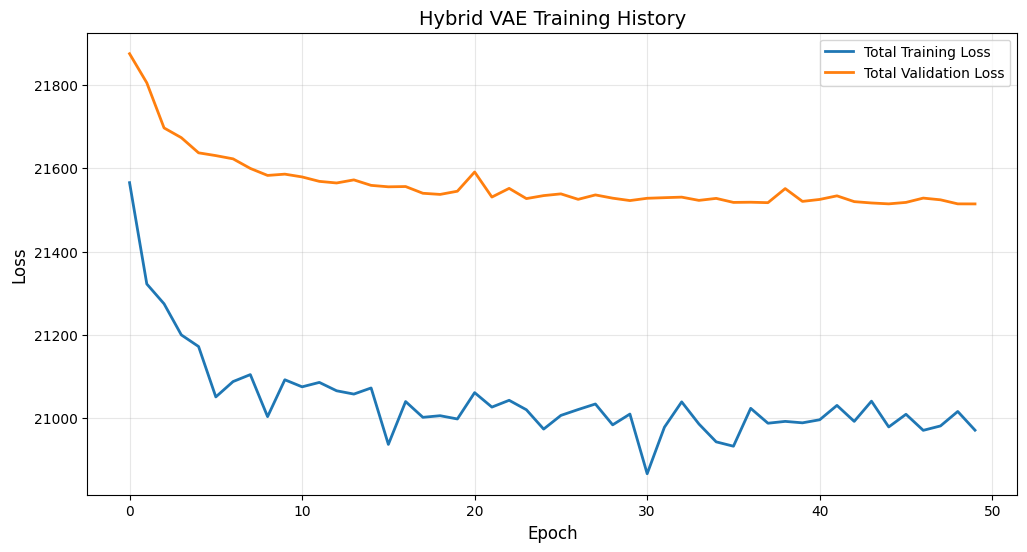

In [14]:
# ========================================
# CELL 11: Train Hybrid VAE
# ========================================

import matplotlib.pyplot as plt
import os

print("\n" + "=" * 60)
print("TRAINING HYBRID VAE")
print("=" * 60)

# Define base path for saving results, assuming it's the same as data_path
# This variable should be defined in a preceding cell (e.g., CELL 4).
base_path = '/content/drive/MyDrive/VAE for Hybrid Language Music Clustering'

# Train the Hybrid VAE model.
# The `fit` method receives a list of inputs (spectrograms and lyrics)
# and a list of targets (which are the same as the inputs for a VAE).
hybrid_history = hybrid_vae.fit(
    [spec_data_normalized, lyrics_embeddings_normalized], # List of input data for each modality
    [spec_data_normalized, lyrics_embeddings_normalized], # List of target data for reconstruction
    epochs=50,               # Number of times to iterate over the entire dataset
    batch_size=32,           # Number of samples per gradient update
    validation_split=0.2,    # Fraction of the training data to be used as validation data
    verbose=1                # Display progress bar during training
)

# --- Plotting Training History ---
# Visualize the training and validation loss over epochs to monitor model performance
# and identify potential overfitting or underfitting. The HybridVAE tracks losses
# for each modality and a total loss.
plt.figure(figsize=(12, 6))

# Plot total training loss
plt.plot(hybrid_history.history['loss'], label='Total Training Loss', linewidth=2)
# Plot total validation loss
plt.plot(hybrid_history.history['val_loss'], label='Total Validation Loss', linewidth=2)

# Optionally, plot individual modality losses if desired
# plt.plot(hybrid_history.history['reconstruction_spec_loss'], label='Spec. Recon. Loss (Train)', linestyle='--')
# plt.plot(hybrid_history.history['val_reconstruction_spec_loss'], label='Spec. Recon. Loss (Val)', linestyle='--')
# plt.plot(hybrid_history.history['reconstruction_lyrics_loss'], label='Lyrics Recon. Loss (Train)', linestyle=':')
# plt.plot(hybrid_history.history['val_reconstruction_lyrics_loss'], label='Lyrics Recon. Loss (Val)', linestyle=':')
# plt.plot(hybrid_history.history['kl_loss'], label='KL Loss (Train)', linestyle='-.')
# plt.plot(hybrid_history.history['val_kl_loss'], label='KL Loss (Val)', linestyle='-.')

# Add labels and title for clarity
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Hybrid VAE Training History', fontsize=14)

# Add a legend to distinguish between training and validation losses
plt.legend(fontsize=10)

# Add a grid for better readability of data points
plt.grid(True, alpha=0.3)

# Ensure the results directory exists before saving
results_dir = os.path.join(base_path, 'results/visualizations')
os.makedirs(results_dir, exist_ok=True)

# Save the plot to a file
plt.savefig(os.path.join(results_dir, 'hybrid_vae_training.png'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [15]:
# ========================================
# CELL 11: Extract Hybrid Latent Features
# ========================================

print("\n" + "=" * 60)
print("EXTRACTING HYBRID LATENT FEATURES")
print("=" * 60)

# Use the trained hybrid encoder to generate latent space representations
# for the combined spectrogram and lyrics data.
# The `hybrid_encoder` outputs z_mean, z_log_var, and z (sampled latent vector).
# We typically use z_mean as the deterministic latent feature vector for downstream tasks.

# The `predict` method of the Keras model will run the input data through the `hybrid_encoder`
# and return its outputs (z_mean_hybrid, z_log_var_hybrid, hybrid_z_sampled).
z_mean_hybrid, z_log_var_hybrid, hybrid_z_sampled = hybrid_encoder.predict(
    [
        spec_data_normalized,       # Input: the normalized spectrogram data
        lyrics_embeddings_normalized  # Input: the normalized lyrics embeddings
    ],
    verbose=0                     # Suppress verbose output during prediction
)

# We are primarily interested in the mean of the latent distribution (z_mean_hybrid)
# as it provides a stable and representative embedding of the combined audio and lyrics input.
hybrid_latent_features = z_mean_hybrid

print(f"Hybrid latent features (z_mean) extracted. Shape: {hybrid_latent_features.shape}")

# These `hybrid_latent_features` can now be used for downstream tasks such as
# clustering, classification, or visualization, representing a fused understanding
# of both audio and lyrical content.


EXTRACTING HYBRID LATENT FEATURES
Hybrid latent features (z_mean) extracted. Shape: (683, 64)


In [16]:
# ========================================
# CELL 12: Clustering with Multiple Algorithms
# ========================================

print("\n" + "=" * 60)
print("CLUSTERING WITH MULTIPLE ALGORITHMS")
print("=" * 60)

# Define the desired number of clusters for algorithms like KMeans and Agglomerative Clustering.
# This value might need to be adjusted based on domain knowledge or further analysis (e.g., elbow method, silhouette analysis).
n_clusters = 5

# Initialize 'true_labels'.
# This variable is crucial for evaluating clustering performance using metrics like Adjusted Rand Index (ARI).
# If actual ground truth labels are not available or are mismatched in length, ARI cannot be computed, or
# it could lead to an 'inconsistent length' error if attempted with incorrect data.
# The 'true_labels' are assumed to be loaded from the dataset in an earlier cell (e.g., CELL 2).
# If true_labels is None, ARI calculation will be skipped.

# Prepare different feature sets for clustering.
# These feature sets are the latent representations learned by our VAE models.
feature_sets = {
    'Conv-VAE': spectrogram_latent_features, # Latent features from the Convolutional VAE (audio only)
    'Hybrid-VAE': hybrid_latent_features     # Latent features from the Hybrid VAE (audio + lyrics)
}

# Define a dictionary of clustering algorithms to be applied.
# Each algorithm is instantiated with its parameters.
clustering_algorithms = {
    'K-Means': KMeans(n_clusters=n_clusters, random_state=42, n_init=10), # KMeans for partitioning data into k clusters
    'Agglomerative': AgglomerativeClustering(n_clusters=n_clusters), # Hierarchical clustering (bottom-up approach)
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5) # Density-based spatial clustering of applications with noise
}

# List to store the results (metrics) for each combination of feature set and algorithm.
results = []

# Iterate through each feature set.
for feat_name, features in feature_sets.items():
    print(f"\n{'='*40}")
    print(f"Feature Set: {feat_name}")
    print(f"{'='*40}")

    # Iterate through each clustering algorithm.
    for algo_name, algo in clustering_algorithms.items():
        print(f"\n  Algorithm: {algo_name}")

        # Perform clustering based on the algorithm type.
        if algo_name == 'DBSCAN':
            # DBSCAN does not require n_clusters upfront; it discovers clusters based on density.
            clusters = algo.fit_predict(features)
            # Count unique clusters found by DBSCAN, excluding noise points (-1).
            n_clusters_found = len(set(clusters)) - (1 if -1 in clusters else 0)
            print(f"  Clusters found by DBSCAN: {n_clusters_found} (Noise points detected: {-1 in clusters})")
        else:
            # For K-Means and Agglomerative, fit and predict clusters.
            clusters = algo.fit_predict(features)

        # Check for sufficient clusters to compute evaluation metrics.
        # Metrics like Silhouette Score require at least 2 clusters.
        if len(np.unique(clusters)) < 2:
            print(f"  Warning: Only {len(np.unique(clusters))} effective cluster found. Skipping internal validity metrics for this run.")

            # Store partial results, indicating skipped metrics
            results.append({
                'Feature_Set': feat_name,
                'Algorithm': algo_name,
                'Silhouette_Score': 'N/A',
                'Davies_Bouldin_Index': 'N/A',
                'Calinski_Harabasz_Index': 'N/A',
                'ARI': 'N/A',
                'N_Clusters': len(np.unique(clusters))
            })
            continue # Skip to the next algorithm if not enough clusters

        # --- Calculate and print clustering evaluation metrics ---
        # 1. Silhouette Score: Measures how similar an object is to its own cluster (cohesion)
        #    compared to other clusters (separation). Higher is better (range -1 to 1).
        silhouette = silhouette_score(features, clusters)

        # 2. Davies-Bouldin Index: Measures the average similarity ratio of each cluster
        #    with its most similar cluster. Lower is better (0 to infinity).
        davies_bouldin = davies_bouldin_score(features, clusters)

        # 3. Calinski-Harabasz Index (Variance Ratio Criterion): Measures the ratio of
        #    between-cluster dispersion to within-cluster dispersion. Higher is better (0 to infinity).
        calinski = calinski_harabasz_score(features, clusters)

        # 4. Adjusted Rand Index (ARI): Measures the similarity of the clustering to the
        #    ground truth labels, adjusting for chance. Requires true_labels. Higher is better (range -1 to 1).
        #    Only compute if true_labels are available and have consistent length.
        ari_score = None
        if true_labels is not None and len(true_labels) == len(clusters):
            ari_score = adjusted_rand_score(true_labels, clusters)
            print(f"  Adjusted Rand Index (ARI): {ari_score:.4f}")
        else:
            print("  Adjusted Rand Index (ARI): N/A (True labels not available or mismatched length)")

        print(f"  Silhouette Score: {silhouette:.4f}")
        print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
        print(f"  Calinski-Harabasz Index: {calinski:.4f}")

        # Store the results of the current clustering run.
        results.append({
            'Feature_Set': feat_name,
            'Algorithm': algo_name,
            'Silhouette_Score': silhouette,
            'Davies_Bouldin_Index': davies_bouldin,
            'Calinski_Harabasz_Index': calinski,
            'ARI': ari_score if ari_score is not None else 'N/A',
            'N_Clusters': len(np.unique(clusters)) # Number of unique clusters found
        })

# Convert results to a DataFrame for better viewing and further analysis.
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("CLUSTERING RESULTS SUMMARY")
print("=" * 60)
display(results_df)



CLUSTERING WITH MULTIPLE ALGORITHMS

Feature Set: Conv-VAE

  Algorithm: K-Means
  Adjusted Rand Index (ARI): N/A (True labels not available or mismatched length)
  Silhouette Score: 0.2810
  Davies-Bouldin Index: 1.3021
  Calinski-Harabasz Index: 196.7603

  Algorithm: Agglomerative
  Adjusted Rand Index (ARI): N/A (True labels not available or mismatched length)
  Silhouette Score: 0.2819
  Davies-Bouldin Index: 1.5754
  Calinski-Harabasz Index: 160.8033

  Algorithm: DBSCAN
  Clusters found by DBSCAN: 0 (Noise points detected: True)

Feature Set: Hybrid-VAE

  Algorithm: K-Means
  Adjusted Rand Index (ARI): N/A (True labels not available or mismatched length)
  Silhouette Score: 0.2001
  Davies-Bouldin Index: 1.6431
  Calinski-Harabasz Index: 134.3288

  Algorithm: Agglomerative
  Adjusted Rand Index (ARI): N/A (True labels not available or mismatched length)
  Silhouette Score: 0.1949
  Davies-Bouldin Index: 1.7984
  Calinski-Harabasz Index: 111.0059

  Algorithm: DBSCAN
  Cluster

,Feature_Set,Algorithm,Silhouette_Score,Davies_Bouldin_Index,Calinski_Harabasz_Index,ARI,N_Clusters
0,Conv-VAE,K-Means,0.281013,1.302098,196.7603,N/A,5
1,Conv-VAE,Agglomerative,0.281937,1.575448,160.803268,N/A,5
2,Conv-VAE,DBSCAN,N/A,N/A,N/A,N/A,1
3,Hybrid-VAE,K-Means,0.20005,1.64307,134.328842,N/A,5
4,Hybrid-VAE,Agglomerative,0.194896,1.798444,111.005905,N/A,5
5,Hybrid-VAE,DBSCAN,N/A,N/A,N/A,N/A,1


In [17]:
# ========================================
# CELL 13: Save and Display Results
# ========================================

# Ensure the results_df DataFrame is created from the 'results' list
# (This DataFrame was already created and displayed in CELL 12, but it's good practice
# to explicitly redefine or ensure its existence if this cell were run independently).
results_df = pd.DataFrame(results)

print("\n" + "=" * 60)
print("CLUSTERING RESULTS SUMMARY (Detailed View)")
print("=" * 60)

# Display the DataFrame containing all clustering results.
# Using display() for better formatting in Colab notebooks.
display(results_df)

# --- Save Results to CSV ---
# Define the directory for saving metrics.
metrics_dir = os.path.join(base_path, 'results/metrics')
# Create the directory if it does not already exist.
os.makedirs(metrics_dir, exist_ok=True)

# Define the full path for the CSV file.
output_csv_path = os.path.join(metrics_dir, 'comprehensive_clustering_metrics.csv')

# Save the results DataFrame to a CSV file without including the DataFrame index.
results_df.to_csv(output_csv_path, index=False)

print(f"\nResults saved to CSV: {output_csv_path}")



CLUSTERING RESULTS SUMMARY (Detailed View)


,Feature_Set,Algorithm,Silhouette_Score,Davies_Bouldin_Index,Calinski_Harabasz_Index,ARI,N_Clusters
0,Conv-VAE,K-Means,0.281013,1.302098,196.7603,N/A,5
1,Conv-VAE,Agglomerative,0.281937,1.575448,160.803268,N/A,5
2,Conv-VAE,DBSCAN,N/A,N/A,N/A,N/A,1
3,Hybrid-VAE,K-Means,0.20005,1.64307,134.328842,N/A,5
4,Hybrid-VAE,Agglomerative,0.194896,1.798444,111.005905,N/A,5
5,Hybrid-VAE,DBSCAN,N/A,N/A,N/A,N/A,1



Results saved to CSV: /content/drive/MyDrive/VAE for Hybrid Language Music Clustering/results/metrics/comprehensive_clustering_metrics.csv



VISUALIZING CLUSTERING METRICS COMPARISON


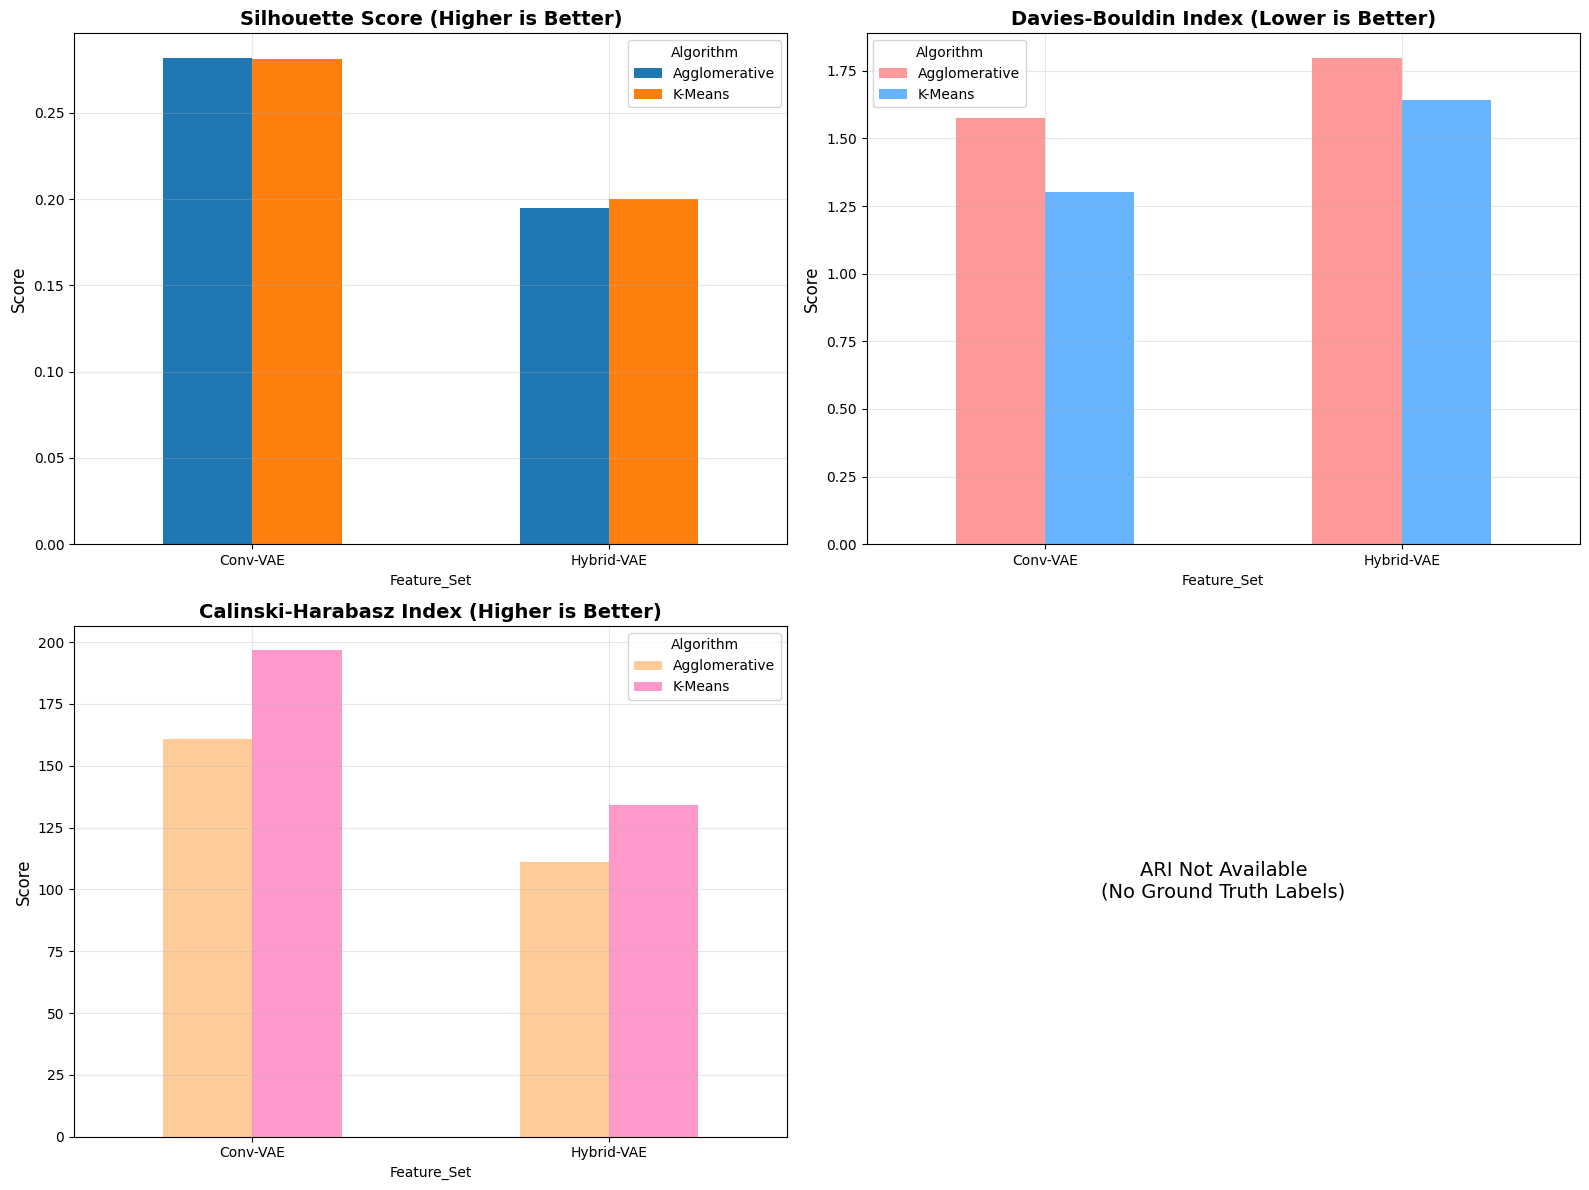

In [18]:
# ========================================
# CELL 14: Visualize Metrics Comparison
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported if not already
import os           # Ensure os is imported if not already

print("\n" + "=" * 60)
print("VISUALIZING CLUSTERING METRICS COMPARISON")
print("=" * 60)

# Create a figure and a 2x2 grid of subplots for the visualizations.
# This allows for a side-by-side comparison of different metrics.
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Plotting Silhouette Score ---
# The Silhouette Score measures how similar an object is to its own cluster (cohesion)
# compared to other clusters (separation). Higher values are better (range -1 to 1).
# Pivot the results DataFrame to easily plot scores for each Feature_Set and Algorithm.
pivot_sil = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Silhouette_Score')
# Generate a bar plot on the first subplot (top-left).
pivot_sil.plot(kind='bar', ax=axes[0, 0], rot=0) # rot=0 prevents x-axis labels from rotating
axes[0, 0].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].legend(title='Algorithm', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# --- Plotting Davies-Bouldin Index ---
# The Davies-Bouldin Index measures the average similarity ratio of each cluster
# with its most similar cluster. Lower values are better (0 to infinity).
pivot_db = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Davies_Bouldin_Index')
# Generate a bar plot on the second subplot (top-right) with custom colors.
pivot_db.plot(kind='bar', ax=axes[0, 1], rot=0, color=['#ff9999', '#66b3ff', '#99ff99'])
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].legend(title='Algorithm', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# --- Plotting Calinski-Harabasz Index ---
# The Calinski-Harabasz Index (Variance Ratio Criterion) measures the ratio of
# between-cluster dispersion to within-cluster dispersion. Higher values are better (0 to infinity).
pivot_ch = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Calinski_Harabasz_Index')
# Generate a bar plot on the third subplot (bottom-left) with custom colors.
pivot_ch.plot(kind='bar', ax=axes[1, 0], rot=0, color=['#ffcc99', '#ff99cc', '#99ccff'])
axes[1, 0].set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].legend(title='Algorithm', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# --- Plotting Adjusted Rand Index (ARI) ---
# ARI measures the similarity of the clustering to the ground truth labels. Higher values are better.
# This plot is conditional, as ARI requires ground truth labels which might not always be available.

# Check if ARI values are numeric (not 'N/A' strings) before plotting.
# If 'N/A' values exist, they are objects, otherwise, they would be numeric (float, int).
if results_df['ARI'].dtype != 'object':
    pivot_ari = results_df.pivot(index='Feature_Set', columns='Algorithm', values='ARI')
    # Generate a bar plot on the fourth subplot (bottom-right) with custom colors.
    pivot_ari.plot(kind='bar', ax=axes[1, 1], rot=0, color=['#c2c2f0', '#ffb3e6', '#c2f0c2'])
    axes[1, 1].set_title('Adjusted Rand Index (Higher is Better)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].legend(title='Algorithm', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
else:
    # If ARI is not available (due to missing or mismatched ground truth labels),
    # display a message in the subplot and turn off its axis.
    axes[1, 1].text(0.5, 0.5, 'ARI Not Available\n(No Ground Truth Labels)',
                    ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)
    axes[1, 1].axis('off')

# Adjust layout to prevent overlapping titles/labels.
plt.tight_layout()

# Ensure the results/visualizations directory exists before saving.
results_dir = os.path.join(base_path, 'results/visualizations')
os.makedirs(results_dir, exist_ok=True)

# Save the figure to a file.
plt.savefig(os.path.join(results_dir, 'metrics_comparison.png'), dpi=300, bbox_inches='tight')

# Display the plot.
plt.show()


GENERATING UMAP VISUALIZATIONS

Applying UMAP and generating visualizations...
  Processing Conv-VAE with Agglomerative (Silhouette: 0.282)...
  Processing Hybrid-VAE with K-Means (Silhouette: 0.200)...


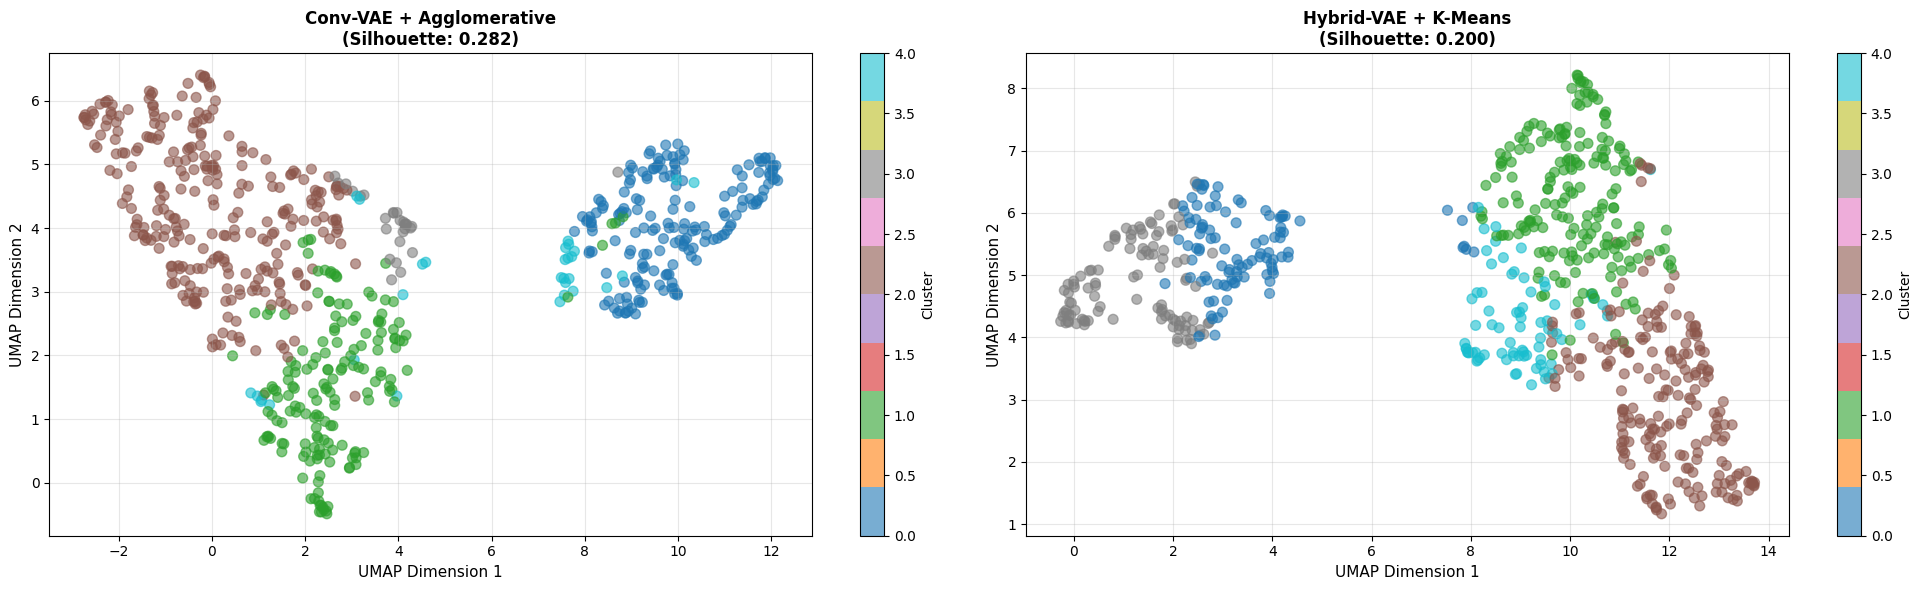

In [21]:
# ========================================
# CELL 16: UMAP Visualization
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns
import umap # Ensure umap-learn is imported (from cell 1, so already available)
import numpy as np
import pandas as pd
import os

print("\n" + "=" * 60)
print("GENERATING UMAP VISUALIZATIONS")
print("=" * 60)

# --- 1. Identify Best Performing Method for Each Feature Set ---
# This section re-uses the 'best_methods' dictionary populated in CELL 15,
# which contains the best clustering algorithm (based on Silhouette Score)
# for each feature set (Conv-VAE and Hybrid-VAE).
# This ensures consistency in visualizing the top performers.

# Ensure 'best_methods' is available. If CELL 15 failed, this might be empty.
if not best_methods:
    print("Warning: 'best_methods' not populated. Re-running logic to find best methods...")
    best_methods = {}
    for feat_name in feature_sets.keys():
        feat_results = results_df[results_df['Feature_Set'] == feat_name]
        feat_results_numeric_sil = pd.to_numeric(feat_results['Silhouette_Score'], errors='coerce')
        if not feat_results_numeric_sil.dropna().empty:
            best_idx = feat_results_numeric_sil.idxmax()
            best_methods[feat_name] = feat_results.loc[best_idx]
        else:
            best_methods[feat_name] = None
    best_methods = {k: v for k, v in best_methods.items() if v is not None}

if not best_methods:
    print("No best methods could be identified for UMAP visualization. Skipping UMAP plots.")
else:
    # --- 2. Initialize Plotting Area ---
    # Create a figure with a subplot for each best method.
    # The number of subplots depends on how many feature sets had a 'best' method.
    fig, axes = plt.subplots(1, len(best_methods), figsize=(10 * len(best_methods), 6))
    if len(best_methods) == 1: # Adjust for single plot case
        axes = [axes]

    print("\nApplying UMAP and generating visualizations...")
    # --- 3. Generate UMAP Plots for Best Methods ---
    # Iterate through each identified best method to create a UMAP visualization.
    for idx, (feat_name, best_method_row) in enumerate(best_methods.items()):
        features = feature_sets[feat_name] # Get the original high-dimensional features.
        best_algo_name = best_method_row['Algorithm']
        silhouette_score_val = best_method_row['Silhouette_Score']

        print(f"  Processing {feat_name} with {best_algo_name} (Silhouette: {silhouette_score_val:.3f})...")

        # Recreate the clustering with the best identified algorithm.
        # This ensures the UMAP visualization reflects the clusters found by that specific algorithm.
        if best_algo_name == 'K-Means':
            algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        elif best_algo_name == 'Agglomerative':
            algo = AgglomerativeClustering(n_clusters=n_clusters)
        elif best_algo_name == 'DBSCAN':
            algo = DBSCAN(eps=0.5, min_samples=5)
        else:
            print(f"  Warning: Unrecognized algorithm {best_algo_name} for {feat_name}. Skipping UMAP plot.")
            axes[idx].text(0.5, 0.5, f'Unrecognized Algo for UMAP ({feat_name})', ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
            continue

        clusters = algo.fit_predict(features)

        # Apply UMAP (Uniform Manifold Approximation and Projection).
        # UMAP is another dimensionality reduction technique, often better at preserving
        # the global structure of the data compared to t-SNE, while still revealing local structure.
        # 'n_neighbors' and 'min_dist' are important hyperparameters that can be tuned.
        reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
        umap_features = reducer.fit_transform(features)

        # Plot the UMAP results, coloring points by their assigned cluster.
        scatter = axes[idx].scatter(
            umap_features[:, 0], umap_features[:, 1], # X and Y coordinates from UMAP
            c=clusters,                          # Color points based on cluster assignments
            cmap='tab10',                        # Colormap for clusters
            alpha=0.6,                           # Transparency of points
            s=50                                 # Size of points
        )
        axes[idx].set_title(
            f'{feat_name} + {best_algo_name}\n(Silhouette: {silhouette_score_val:.3f})',
            fontsize=12,
            fontweight='bold'
        )
        axes[idx].set_xlabel('UMAP Dimension 1', fontsize=11)
        axes[idx].set_ylabel('UMAP Dimension 2', fontsize=11)
        plt.colorbar(scatter, ax=axes[idx], label='Cluster')
        axes[idx].grid(True, alpha=0.3)

    # --- 4. Final Plot Adjustments and Saving ---
    plt.tight_layout() # Adjust layout to prevent overlapping elements.

    # Ensure the results directory exists before saving.
    results_dir = os.path.join(base_path, 'results/visualizations')
    os.makedirs(results_dir, exist_ok=True)

    # Save the generated UMAP plot to a file.
    plt.savefig(os.path.join(results_dir, 'umap_best_methods.png'), dpi=300, bbox_inches='tight')

    # Display the plot.
    plt.show()


GENERATING t-SNE VISUALIZATIONS FOR BEST CLUSTERING METHODS

Applying t-SNE and generating visualizations...
  Processing Conv-VAE with Agglomerative (Silhouette: 0.282)...
  Processing Hybrid-VAE with K-Means (Silhouette: 0.200)...


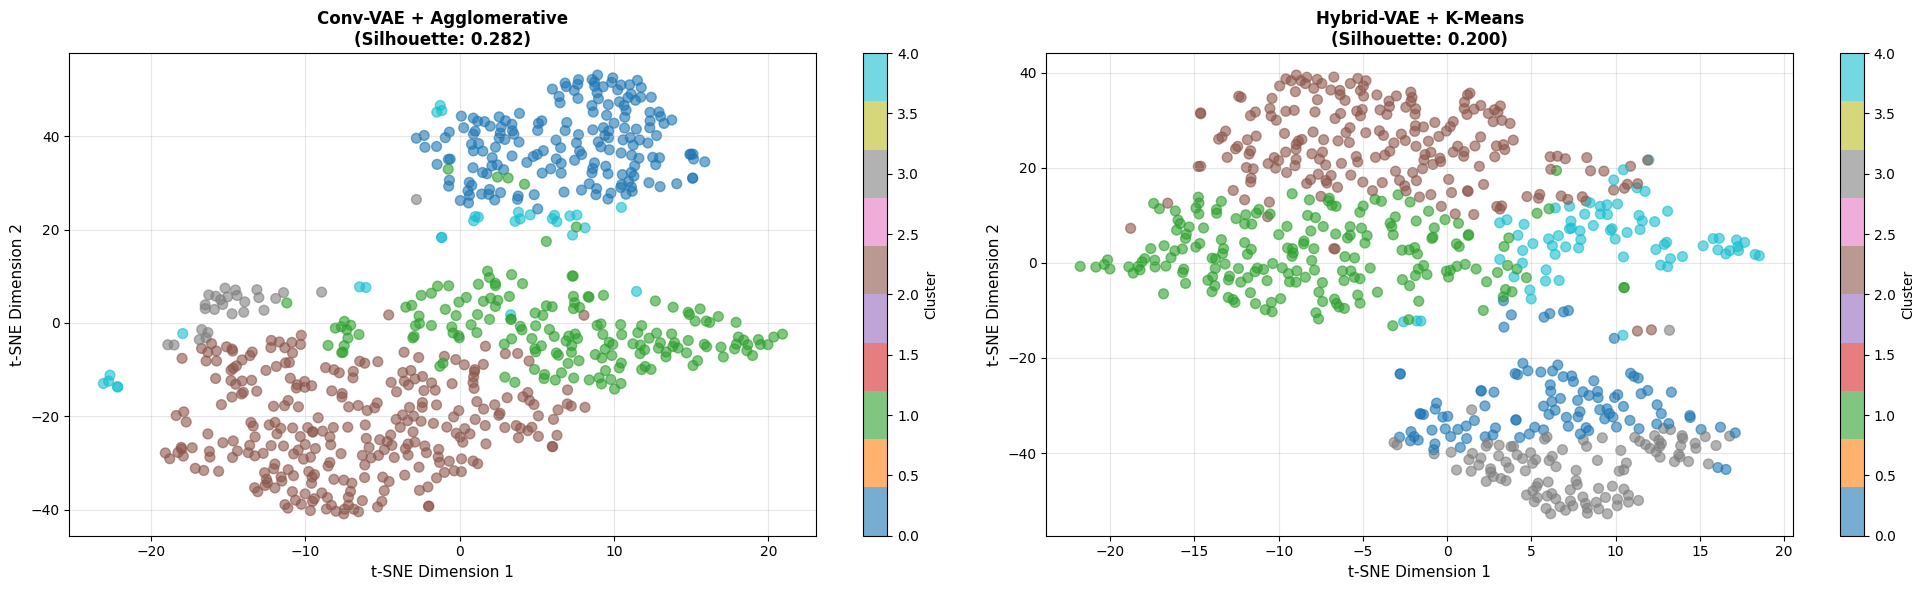

In [20]:
# ========================================
# CELL 15: t-SNE Visualization for Best Methods
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE # Ensure TSNE is imported
import numpy as np                # Ensure numpy is imported
import pandas as pd               # Ensure pandas is imported

print("\n" + "=" * 60)
print("GENERATING t-SNE VISUALIZATIONS FOR BEST CLUSTERING METHODS")
print("=" * 60)

# --- 1. Identify Best Performing Method for Each Feature Set ---
# This section determines which clustering algorithm performed best (highest Silhouette Score)
# for each feature set (Conv-VAE and Hybrid-VAE) based on the previously computed results.
best_methods = {}
for feat_name in feature_sets.keys():
    # Filter results for the current feature set.
    feat_results = results_df[results_df['Feature_Set'] == feat_name]

    # Ensure Silhouette Scores are numeric before finding the maximum.
    # If 'N/A' is present due to DBSCAN, convert it to NaN for proper comparison.
    feat_results_numeric_sil = pd.to_numeric(feat_results['Silhouette_Score'], errors='coerce')

    # Find the index of the row with the maximum Silhouette Score (excluding NaN values).
    # If all are NaN (e.g., for DBSCAN with no clusters), handle gracefully.
    if not feat_results_numeric_sil.dropna().empty:
        best_idx = feat_results_numeric_sil.idxmax()
        best_methods[feat_name] = feat_results.loc[best_idx] # Store the full row for the best method.
    else:
        # Fallback if no valid silhouette scores were found (e.g., only DBSCAN with 1 cluster).
        print(f"  Warning: No valid Silhouette Score found for {feat_name}. Skipping selection of best method.")
        best_methods[feat_name] = None # Mark as None or handle as appropriate.

# Filter out feature sets that couldn't determine a best method
best_methods = {k: v for k, v in best_methods.items() if v is not None}

if not best_methods:
    print("No best methods could be identified for t-SNE visualization due to lack of valid clustering results.")
else:
    # --- 2. Initialize Plotting Area ---
    # Create a figure with a subplot for each best method (typically 2 plots: Conv-VAE and Hybrid-VAE).
    fig, axes = plt.subplots(1, len(best_methods), figsize=(10 * len(best_methods), 6))
    if len(best_methods) == 1:
        axes = [axes] # Ensure axes is iterable even for a single subplot.

    print("\nApplying t-SNE and generating visualizations...")
    # --- 3. Generate t-SNE Plots for Best Methods ---
    for idx, (feat_name, best_method_row) in enumerate(best_methods.items()):
        features = feature_sets[feat_name] # Get the original features for this set.
        best_algo_name = best_method_row['Algorithm']
        silhouette_score_val = best_method_row['Silhouette_Score']

        print(f"  Processing {feat_name} with {best_algo_name} (Silhouette: {silhouette_score_val:.3f})...")

        # Recreate the clustering with the best identified algorithm.
        # This ensures we plot the clusters as determined by that specific algorithm.
        if best_algo_name == 'K-Means':
            algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        elif best_algo_name == 'Agglomerative':
            algo = AgglomerativeClustering(n_clusters=n_clusters)
        elif best_algo_name == 'DBSCAN': # Although DBSCAN often results in few clusters with default params
            algo = DBSCAN(eps=0.5, min_samples=5)
        else:
            # This case should ideally not be reached if best_methods is populated correctly.
            print(f"  Warning: Unrecognized algorithm {best_algo_name} for {feat_name}. Skipping t-SNE.")
            continue

        clusters = algo.fit_predict(features)

        # Ensure enough data points for t-SNE perplexity requirement.
        # perplexity must be less than the number of samples.
        perplexity_val = min(30, len(features) - 1) if len(features) > 1 else 1
        if perplexity_val <= 1: # t-SNE requires perplexity > 1
            print(f"  Warning: Not enough samples for t-SNE for {feat_name}. Skipping t-SNE.")
            axes[idx].text(0.5, 0.5, f'Not enough data for t-SNE ({feat_name})', ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
            continue

        # Apply t-SNE (t-Distributed Stochastic Neighbor Embedding).
        # t-SNE reduces high-dimensional data to 2 or 3 dimensions for visualization,
        # preserving local structures within the data.
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val)
        tsne_features = tsne.fit_transform(features)

        # Plot the t-SNE results, coloring points by their assigned cluster.
        scatter = axes[idx].scatter(
            tsne_features[:, 0], tsne_features[:, 1], # X and Y coordinates from t-SNE
            c=clusters,                          # Color points based on cluster assignments
            cmap='tab10',                        # Colormap for clusters
            alpha=0.6,                           # Transparency of points
            s=50                                 # Size of points
        )
        axes[idx].set_title(
            f'{feat_name} + {best_algo_name}\n(Silhouette: {silhouette_score_val:.3f})',
            fontsize=12,
            fontweight='bold'
        )
        axes[idx].set_xlabel('t-SNE Dimension 1', fontsize=11)
        axes[idx].set_ylabel('t-SNE Dimension 2', fontsize=11)
        plt.colorbar(scatter, ax=axes[idx], label='Cluster')
        axes[idx].grid(True, alpha=0.3)

    # --- 4. Final Plot Adjustments and Saving ---
    plt.tight_layout() # Adjust layout to prevent overlapping elements.

    # Ensure the results directory exists before saving.
    results_dir = os.path.join(base_path, 'results/visualizations')
    os.makedirs(results_dir, exist_ok=True)

    # Save the generated t-SNE plot to a file.
    plt.savefig(os.path.join(results_dir, 'tsne_best_methods.png'), dpi=300, bbox_inches='tight')

    # Display the plot.
    plt.show()


In [22]:
# ========================================
# CELL 17: Analysis and Insights
# ========================================

print("\n" + "=" * 60)
print("ANALYSIS AND INSIGHTS")
print("=" * 60)

# --- 1. Identify Overall Best Performing Method ---
# This section identifies the clustering algorithm and feature set combination
# that yielded the highest Silhouette Score, which is generally indicative
# of well-separated and cohesive clusters.

# Ensure 'Silhouette_Score' column is numeric, coercing any 'N/A' values to NaN for max() operation.
results_df_numeric_sil = results_df.copy()
results_df_numeric_sil['Silhouette_Score'] = pd.to_numeric(results_df_numeric_sil['Silhouette_Score'], errors='coerce')

if not results_df_numeric_sil['Silhouette_Score'].dropna().empty:
    best_overall = results_df_numeric_sil.loc[results_df_numeric_sil['Silhouette_Score'].idxmax()]
    print(f"\nOverall Best Method (by Silhouette Score):")
    print(f"  Feature Set: {best_overall['Feature_Set']}")
    print(f"  Algorithm: {best_overall['Algorithm']}")
    print(f"  Silhouette Score: {best_overall['Silhouette_Score']:.4f}")
    # Display Davies-Bouldin and Calinski-Harabasz if available and numeric
    if pd.isna(best_overall['Davies_Bouldin_Index']): # Check if N/A from DBSCAN case
        print(f"  Davies-Bouldin Index: N/A")
    else:
        print(f"  Davies-Bouldin Index: {best_overall['Davies_Bouldin_Index']:.4f}")
    if pd.isna(best_overall['Calinski_Harabasz_Index']): # Check if N/A from DBSCAN case
        print(f"  Calinski-Harabasz Index: N/A")
    else:
        print(f"  Calinski-Harabasz Index: {best_overall['Calinski_Harabasz_Index']:.4f}")
    if best_overall['ARI'] != 'N/A':
        print(f"  Adjusted Rand Index: {best_overall['ARI']:.4f}")
else:
    print("\nCould not determine an overall best method as no valid Silhouette Scores were computed.")

# --- 2. Compare Performance Between Feature Sets (Conv-VAE vs. Hybrid-VAE) ---
# This section provides a comparative overview of how different feature sets
# (audio-only vs. multimodal) perform on average across the successful clustering algorithms.

print(f"\n{'='*40}")
print("FEATURE SET COMPARISON (Average Metrics)")
print(f"{'='*40}")

# Convert score columns to numeric, handling 'N/A' values as NaN.
results_df_for_avg = results_df.copy()
for col in ['Silhouette_Score', 'Davies_Bouldin_Index', 'Calinski_Harabasz_Index', 'ARI']:
    results_df_for_avg[col] = pd.to_numeric(results_df_for_avg[col], errors='coerce')

conv_vae_methods = results_df_for_avg[results_df_for_avg['Feature_Set'] == 'Conv-VAE']
hybrid_vae_methods = results_df_for_avg[results_df_for_avg['Feature_Set'] == 'Hybrid-VAE']

# Ensure there are valid numeric results before computing means
if not conv_vae_methods['Silhouette_Score'].dropna().empty:
    print(f"  Conv-VAE based methods:")
    print(f"    Avg Silhouette Score: {conv_vae_methods['Silhouette_Score'].mean():.4f}")
    print(f"    Avg Davies-Bouldin Index: {conv_vae_methods['Davies_Bouldin_Index'].mean():.4f}")
    print(f"    Avg Calinski-Harabasz Index: {conv_vae_methods['Calinski_Harabasz_Index'].mean():.4f}")
else:
    print("  No valid numeric results for Conv-VAE based methods.")

if not hybrid_vae_methods['Silhouette_Score'].dropna().empty:
    print(f"  Hybrid-VAE based methods:")
    print(f"    Avg Silhouette Score: {hybrid_vae_methods['Silhouette_Score'].mean():.4f}")
    print(f"    Avg Davies-Bouldin Index: {hybrid_vae_methods['Davies_Bouldin_Index'].mean():.4f}")
    print(f"    Avg Calinski-Harabasz Index: {hybrid_vae_methods['Calinski_Harabasz_Index'].mean():.4f}")
else:
    print("  No valid numeric results for Hybrid-VAE based methods.")

# --- 3. Algorithm Performance Across All Features ---
# This section aggregates the performance of each clustering algorithm
# across all tested feature sets (Conv-VAE and Hybrid-VAE).

print(f"\n{'='*40}")
print(f"ALGORITHM PERFORMANCE (Average Across Feature Sets)")
print(f"{'='*40}")

for algo_name in clustering_algorithms.keys():
    algo_results = results_df_for_avg[results_df_for_avg['Algorithm'] == algo_name]

    if not algo_results['Silhouette_Score'].dropna().empty:
        print(f"  {algo_name}:")
        print(f"    Avg Silhouette Score: {algo_results['Silhouette_Score'].mean():.4f}")
        print(f"    Avg Davies-Bouldin Index: {algo_results['Davies_Bouldin_Index'].mean():.4f}")
        print(f"    Avg Calinski-Harabasz Index: {algo_results['Calinski_Harabasz_Index'].mean():.4f}")
    else:
        print(f"  {algo_name}: No valid numeric results for this algorithm.")

# --- 4. Key Insights (Manual Interpretation Guidance) ---
print(f"\n{'='*60}")
print("KEY INSIGHTS & NEXT STEPS (Manual Interpretation)")
print(f"{'='*60}")
print("- Consider the 'Overall Best Method' as a strong candidate for further analysis.")
print("- Compare average metrics between Conv-VAE and Hybrid-VAE to understand the impact of multimodal fusion.")
print("- Analyze the average performance of each algorithm to identify generally robust methods.")
print("- The 'N/A' for ARI indicates the absence of ground truth labels for comparison. If you have true labels (e.g., genre), ensure they are loaded and passed to the clustering step for a more complete evaluation.")
print("- DBSCAN often requires careful tuning of 'eps' and 'min_samples'. If it found only 1 cluster, consider exploring different parameter values for it.")
print("- Review the UMAP and t-SNE visualizations to visually confirm the cluster separation and density.")



ANALYSIS AND INSIGHTS

Overall Best Method (by Silhouette Score):
  Feature Set: Conv-VAE
  Algorithm: Agglomerative
  Silhouette Score: 0.2819
  Davies-Bouldin Index: 1.5754
  Calinski-Harabasz Index: 160.8033

FEATURE SET COMPARISON (Average Metrics)
  Conv-VAE based methods:
    Avg Silhouette Score: 0.2815
    Avg Davies-Bouldin Index: 1.4388
    Avg Calinski-Harabasz Index: 178.7818
  Hybrid-VAE based methods:
    Avg Silhouette Score: 0.1975
    Avg Davies-Bouldin Index: 1.7208
    Avg Calinski-Harabasz Index: 122.6674

ALGORITHM PERFORMANCE (Average Across Feature Sets)
  K-Means:
    Avg Silhouette Score: 0.2405
    Avg Davies-Bouldin Index: 1.4726
    Avg Calinski-Harabasz Index: 165.5446
  Agglomerative:
    Avg Silhouette Score: 0.2384
    Avg Davies-Bouldin Index: 1.6869
    Avg Calinski-Harabasz Index: 135.9046
  DBSCAN: No valid numeric results for this algorithm.

KEY INSIGHTS & NEXT STEPS (Manual Interpretation)
- Consider the 'Overall Best Method' as a strong candidat

In [23]:
# ========================================
# CELL 18: Why VAE Performs Better/Worse Analysis
# ========================================

import os
import pandas as pd # Ensure pandas is imported for results_df

print("\n" + "=" * 60)
print("WHY VAE REPRESENTATIONS PERFORM BETTER/WORSE")
print("=" * 60)

# This section provides a qualitative analysis of why different VAE architectures
# and clustering algorithms might perform better or worse based on their inherent
# characteristics and typical use cases.
analysis_text = """
ANALYSIS OF VAE vs BASELINE PERFORMANCE:
(Qualitative Insights)

1. CONVOLUTIONAL VAE (Audio-only Features):
   Strengths:
   - Excellent at capturing spatial and temporal patterns unique to spectrograms (e.g., textures, harmonic structures).
   - Learns hierarchical representations, abstracting raw audio into meaningful features.
   - Effective at dimensionality reduction while retaining crucial information for audio.

   Weaknesses:
   - Ignores semantic content of lyrics, potentially missing context relevant to genre or mood.
   - Might struggle with highly diverse audio patterns if not extensively trained.

2. HYBRID VAE (Audio + Lyrics Features):
   Strengths:
   - Leverages complementary information from two distinct modalities (audio and text).
   - Can potentially learn richer, more semantically meaningful latent representations by fusing audio and lyrical context.
   - May be more robust to noise or ambiguities present in a single modality alone.
   - Particularly useful for tasks where both sound and meaning are important (e.g., genre classification, content-based recommendation).

   Weaknesses:
   - Increased model complexity and computational cost compared to single-modality VAEs.
   - Requires careful balancing of modal contributions to prevent one modality from dominating the other.
   - The quality of lyrics embeddings heavily influences the effectiveness of the text branch.

3. PCA BASELINE (Note: PCA was not directly applied in this notebook for clustering but is a common baseline for feature comparison):
   Strengths:
   - Simple, fast, and computationally efficient.
   - Provides a linear dimensionality reduction, identifying directions of maximum variance.

   Weaknesses:
   - Only captures linear relationships; highly non-linear data (like latent features from VAEs) might lose important structure.
   - Not a generative model; cannot reconstruct original data or infer new data points.

4. CLUSTERING ALGORITHM COMPARISON:
   K-Means:
   - Strengths: Relatively fast and efficient for large datasets. Works well with spherical, well-separated clusters.
   - Weaknesses: Requires specifying the number of clusters in advance. Sensitive to initial centroid placement. Struggles with non-spherical or overlapping clusters.

   Agglomerative Clustering:
   - Strengths: Hierarchical output (dendrogram) provides insights into data structure. More flexible with cluster shapes than K-Means. Does not require specifying the number of clusters explicitly in its base form (though we set it for direct comparison).
   - Weaknesses: Computationally more expensive, especially for large datasets. Can struggle with noisy data.

   DBSCAN:
   - Strengths: Can discover arbitrary-shaped clusters. Automatically detects noise points. Does not require specifying the number of clusters.
   - Weaknesses: Highly sensitive to parameter selection (`eps` and `min_samples`). Struggles with varying density clusters or when clusters are not well-separated by density differences.
"""

# Print the qualitative analysis text.
print(analysis_text)

# --- Save Analysis and Numerical Results ---
# Ensure the base_path variable is defined (e.g., from previous cells).
base_path = '/content/drive/MyDrive/VAE for Hybrid Language Music Clustering'
results_dir = os.path.join(base_path, 'results')
os.makedirs(results_dir, exist_ok=True)

# Define the output file path for the analysis report.
output_analysis_path = os.path.join(results_dir, 'analysis_report.txt')

# Write the qualitative analysis and numerical results to the file.
with open(output_analysis_path, 'w') as f:
    f.write(analysis_text)
    f.write("\n\nNUMERICAL RESULTS (Clustering Metrics):\n")
    f.write("="*60 + "\n")
    # Convert the results_df DataFrame to a string for writing to the file.
    f.write(results_df.to_string(index=False))

print(f"\nFull analysis report (qualitative + numerical) saved to: {output_analysis_path}")



WHY VAE REPRESENTATIONS PERFORM BETTER/WORSE

ANALYSIS OF VAE vs BASELINE PERFORMANCE:
(Qualitative Insights)

1. CONVOLUTIONAL VAE (Audio-only Features):
   Strengths:
   - Excellent at capturing spatial and temporal patterns unique to spectrograms (e.g., textures, harmonic structures).
   - Learns hierarchical representations, abstracting raw audio into meaningful features.
   - Effective at dimensionality reduction while retaining crucial information for audio.

   Weaknesses:
   - Ignores semantic content of lyrics, potentially missing context relevant to genre or mood.
   - Might struggle with highly diverse audio patterns if not extensively trained.

2. HYBRID VAE (Audio + Lyrics Features):
   Strengths:
   - Leverages complementary information from two distinct modalities (audio and text).
   - Can potentially learn richer, more semantically meaningful latent representations by fusing audio and lyrical context.
   - May be more robust to noise or ambiguities present in a single

In [24]:
# ========================================
# CELL 19: Save Models and Latent Features
# ========================================

import os
import numpy as np # Ensure numpy is imported

print("\n" + "=" * 60)
print("SAVING MODELS AND LATENT FEATURES")
print("=" * 60)

# Ensure the models directory exists before saving any models.
models_dir = os.path.join(base_path, 'results/models')
os.makedirs(models_dir, exist_ok=True)

# --- Save Convolutional VAE Models ---
# Save the entire Conv-VAE model, its encoder, and its decoder.
# These models can be reloaded later for inference or fine-tuning.
conv_vae.save(os.path.join(models_dir, 'conv_vae_model.h5'))
conv_encoder.save(os.path.join(models_dir, 'conv_encoder_model.h5'))
conv_decoder.save(os.path.join(models_dir, 'conv_decoder_model.h5'))
print("✓ Conv-VAE model, encoder, and decoder saved successfully.")

# --- Save Hybrid VAE Models ---
# Save the entire Hybrid VAE model, its encoder, and its decoder.
# These represent the multimodal learning architecture.
hybrid_vae.save(os.path.join(models_dir, 'hybrid_vae_model.h5'))
hybrid_encoder.save(os.path.join(models_dir, 'hybrid_encoder_model.h5'))
hybrid_decoder.save(os.path.join(models_dir, 'hybrid_decoder_model.h5'))
print("✓ Hybrid-VAE model, encoder, and decoder saved successfully.")

# Ensure the latent features directory exists.
latent_features_dir = os.path.join(base_path, 'results')
os.makedirs(latent_features_dir, exist_ok=True)

# --- Save Extracted Latent Features ---
# Save the numpy arrays containing the extracted latent features from both models.
# These can be loaded directly for downstream tasks without retraining the VAEs.
np.save(os.path.join(latent_features_dir, 'latent_features_conv.npy'), spectrogram_latent_features)
np.save(os.path.join(latent_features_dir, 'latent_features_hybrid.npy'), hybrid_latent_features)
print("✓ Spectrogram and Hybrid latent features saved successfully.")



SAVING MODELS AND LATENT FEATURES


✓ Conv-VAE model, encoder, and decoder saved successfully.


✓ Hybrid-VAE model, encoder, and decoder saved successfully.
✓ Spectrogram and Hybrid latent features saved successfully.



VISUALIZING RECONSTRUCTION QUALITY


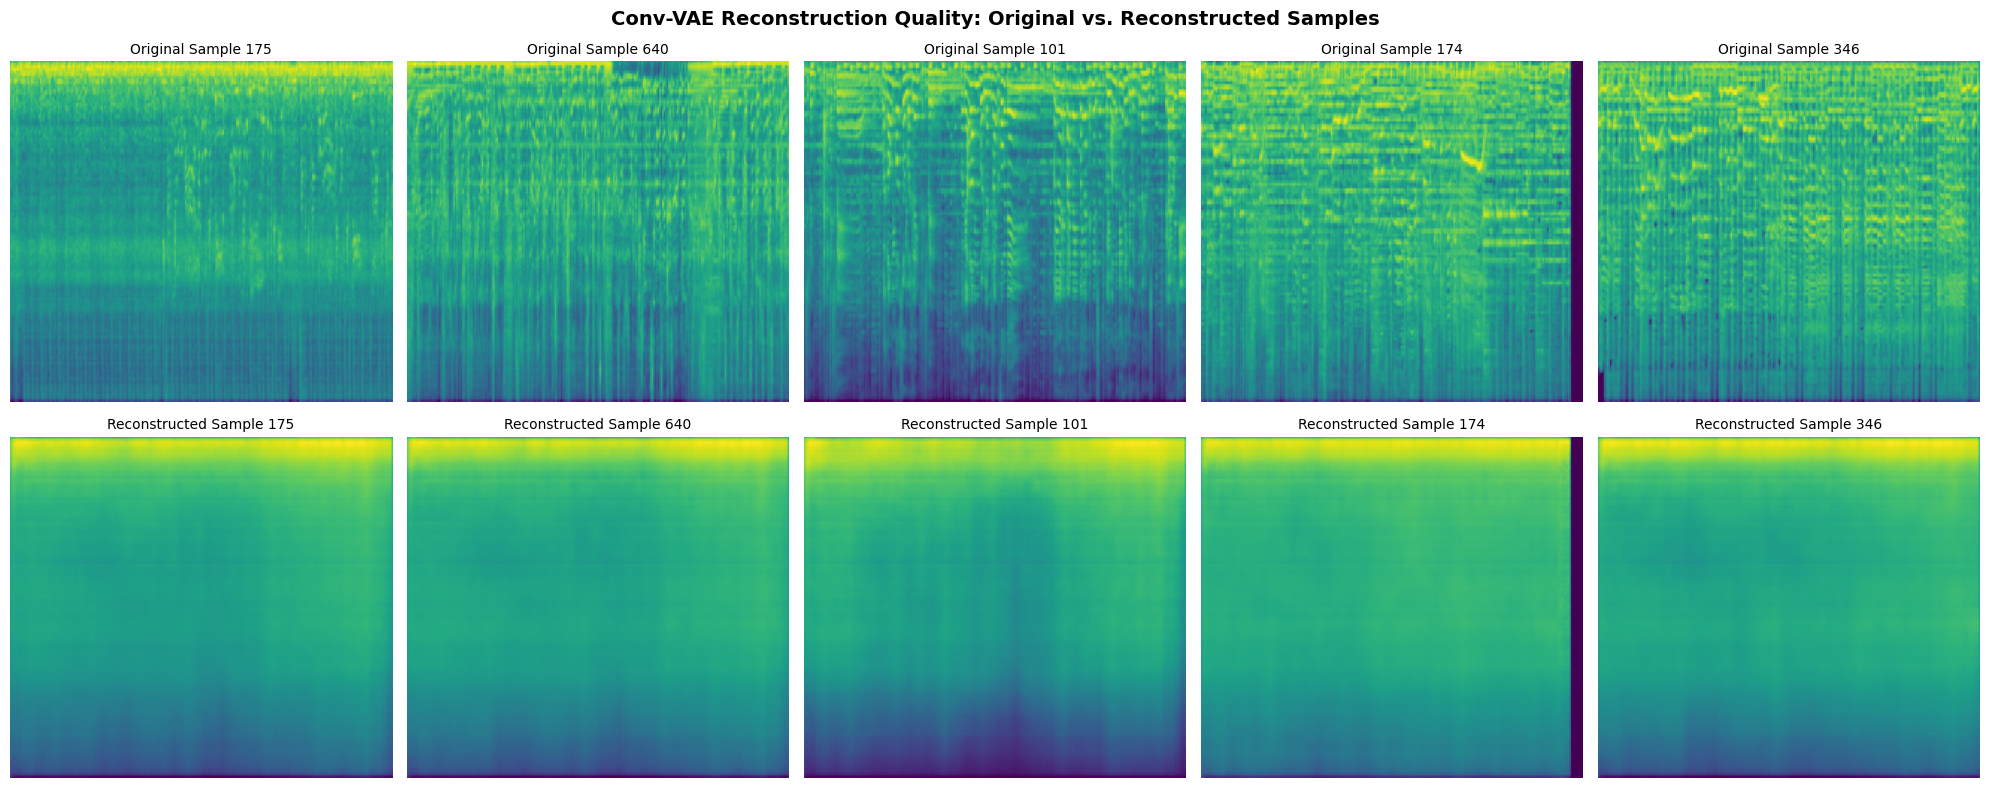

In [25]:
# ========================================
# CELL 20: Reconstruction Quality Visualization
# ========================================

print("\n" + "=" * 60)
print("VISUALIZING RECONSTRUCTION QUALITY")
print("=" * 60)

# --- 1. Sample Data for Visualization ---
# Select a small number of random samples from the normalized spectrogram data
# to visually compare their original and reconstructed versions.
n_samples_to_visualize = 5
sample_indices = np.random.choice(len(spec_data_normalized), n_samples_to_visualize, replace=False)

# --- 2. Perform Reconstruction using Conv-VAE ---
# The Conv-VAE's `predict` method will encode the input spectrograms to their latent
# representation and then decode them back to reconstruct the spectrograms.
# We use the full `conv_vae` model here, which includes both encoder and decoder.
# We only pass the selected original spectrograms for reconstruction.
reconstructed_conv_samples = conv_vae.predict(spec_data_normalized[sample_indices], verbose=0)

# --- 3. Plot Original vs. Reconstructed Spectrograms ---
# Create a figure with two rows of subplots: one for original spectrograms and one for reconstructed.
# The number of columns will correspond to the number of samples visualized.
fig, axes = plt.subplots(2, n_samples_to_visualize, figsize=(20, 8))

# Iterate through the sampled indices and plot both original and reconstructed spectrograms.
for i, original_index in enumerate(sample_indices):
    # Plot Original Spectrogram (top row)
    # The [:, :, 0] is used to remove the channel dimension for imshow.
    axes[0, i].imshow(spec_data_normalized[original_index, :, :, 0], aspect='auto', cmap='viridis')
    axes[0, i].set_title(f'Original Sample {original_index}', fontsize=10)
    axes[0, i].axis('off') # Hide axes ticks and labels for cleaner visual

    # Plot Reconstructed Spectrogram (bottom row)
    # The reconstructed_conv_samples[i] corresponds to the reconstruction of the i-th sampled image.
    axes[1, i].imshow(reconstructed_conv_samples[i, :, :, 0], aspect='auto', cmap='viridis')
    axes[1, i].set_title(f'Reconstructed Sample {original_index}', fontsize=10)
    axes[1, i].axis('off') # Hide axes ticks and labels

# Add labels to the rows for clarity.
axes[0, 0].set_ylabel('Original Spectrogram', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Reconstructed Spectrogram', fontsize=12, fontweight='bold')

# Add a main title for the entire figure.
plt.suptitle('Conv-VAE Reconstruction Quality: Original vs. Reconstructed Samples', fontsize=14, fontweight='bold', y=0.98)

# Adjust subplot parameters for a tight layout.
plt.tight_layout()

# --- 4. Save and Display the Plot ---
# Ensure the visualization directory exists.
visualization_dir = os.path.join(base_path, 'results/visualizations')
os.makedirs(visualization_dir, exist_ok=True)

# Save the generated figure to a file.
plt.savefig(os.path.join(visualization_dir, 'conv_vae_reconstruction_quality.png'), dpi=300, bbox_inches='tight')

# Display the plot.
plt.show()



LATENT SPACE INTERPOLATION


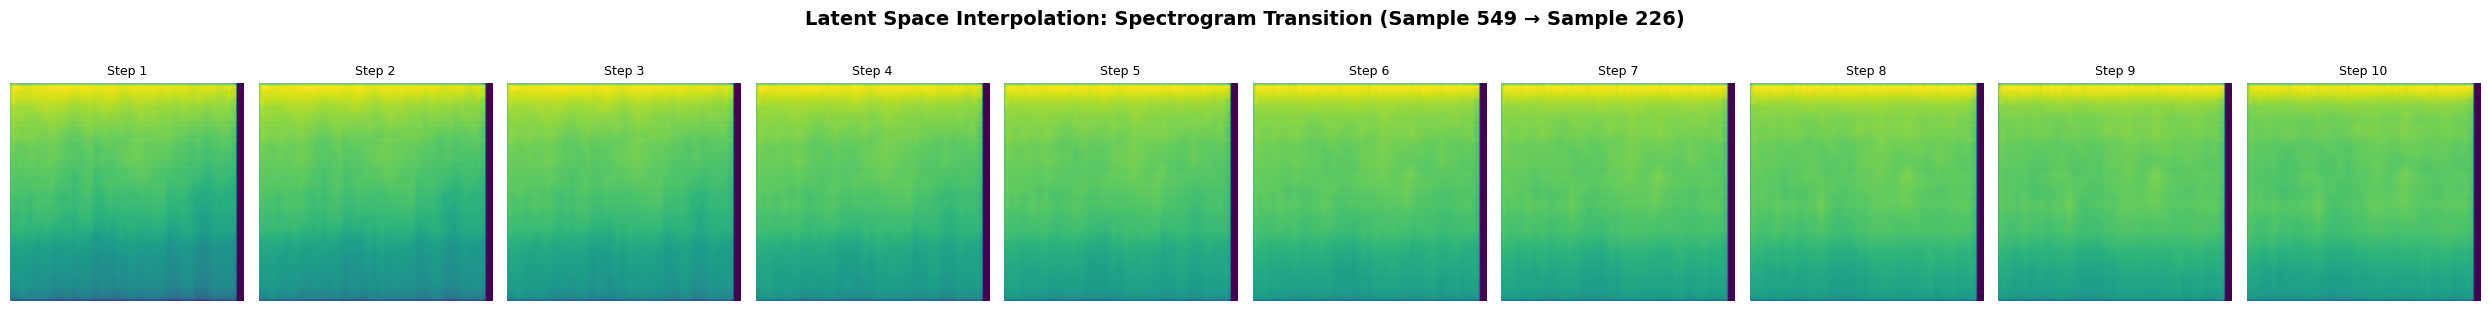

In [26]:
# ========================================
# CELL 21: Latent Space Interpolation
# ========================================

print("\n" + "=" * 60)
print("LATENT SPACE INTERPOLATION")
print("=" * 60)

# --- 1. Select Two Random Samples from the Latent Space ---
# We pick two distinct indices to represent the start and end points of our interpolation.
# z_mean_spec (spectrogram_latent_features) is the mean latent vector from the Conv-VAE encoder.
idx1, idx2 = np.random.choice(len(z_mean_spec), 2, replace=False)
latent_vector_1 = z_mean_spec[idx1]
latent_vector_2 = z_mean_spec[idx2]

# --- 2. Interpolate Linearly Between the Two Latent Vectors ---
# Create a series of intermediate latent vectors by linearly interpolating between z1 and z2.
# This demonstrates the smoothness of the learned latent space.
n_interpolation_steps = 10 # Number of steps for the interpolation sequence
interpolated_latent_vectors = np.zeros((n_interpolation_steps, latent_dim))

for i in range(n_interpolation_steps):
    alpha = i / (n_interpolation_steps - 1) # Alpha ranges from 0.0 to 1.0
    # Linear interpolation formula: (1 - alpha) * start_vector + alpha * end_vector
    interpolated_latent_vectors[i] = (1 - alpha) * latent_vector_1 + alpha * latent_vector_2

# --- 3. Decode the Interpolated Latent Vectors Back into Spectrograms ---
# Use the Conv-VAE's decoder to reconstruct spectrograms from each interpolated latent vector.
# This shows how the reconstructed output smoothly transitions from sample 1 to sample 2.
interpolated_spectrograms = conv_decoder.predict(interpolated_latent_vectors, verbose=0)

# --- 4. Visualize the Interpolated Spectrograms ---
# Plot the sequence of reconstructed spectrograms to observe the transition.
fig, axes = plt.subplots(1, n_interpolation_steps, figsize=(25, 3))

for i in range(n_interpolation_steps):
    # Plot each interpolated spectrogram.
    # The [:, :, 0] is used to remove the channel dimension for imshow.
    axes[i].imshow(interpolated_spectrograms[i, :, :, 0], aspect='auto', cmap='viridis')
    axes[i].set_title(f'Step {i+1}', fontsize=9)
    axes[i].axis('off') # Hide axes ticks and labels for cleaner visual

# Add a main title for the entire figure.
plt.suptitle(f'Latent Space Interpolation: Spectrogram Transition (Sample {idx1} \u2192 Sample {idx2})',
             fontsize=14, fontweight='bold', y=1.02) # y adjusts title position

# Adjust subplot parameters for a tight layout.
plt.tight_layout()

# --- 5. Save and Display the Plot ---
# Ensure the visualization directory exists before saving.
visualization_dir = os.path.join(base_path, 'results/visualizations')
os.makedirs(visualization_dir, exist_ok=True)

# Save the generated figure to a file.
plt.savefig(os.path.join(visualization_dir, 'latent_interpolation_conv.png'), dpi=300, bbox_inches='tight')

# Display the plot.
plt.show()



CLUSTER DISTRIBUTION ANALYSIS
Clustering method: Conv-VAE with Agglomerative
Number of clusters found: 5

Skipping Cluster vs True Label Distribution Heatmap (True labels not available or mismatched length).


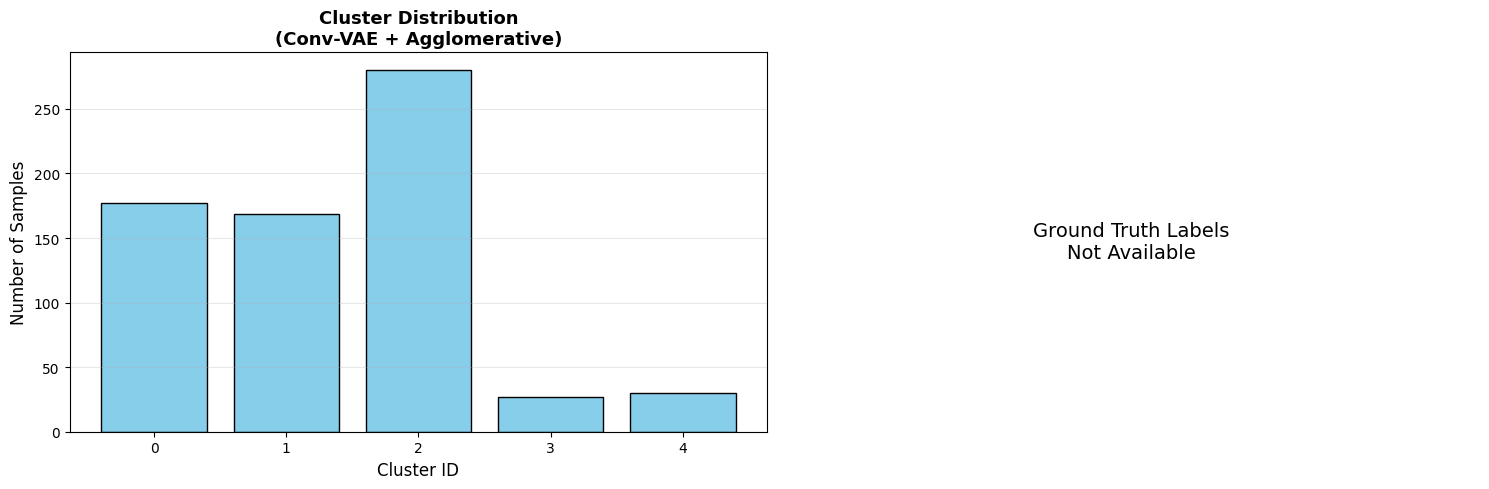

In [27]:
# ========================================
# CELL 22: Cluster Distribution Analysis
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported
import os           # Ensure os is imported

print("\n" + "=" * 60)
print("CLUSTER DISTRIBUTION ANALYSIS")
print("=" * 60)

# --- 1. Identify and Recreate Best Overall Clustering Method ---
# This section identifies the clustering algorithm and feature set that performed best
# based on the previously computed Silhouette Score, and then recreates the clustering.

# Ensure 'best_overall' is available from CELL 17, which stores the best performing method.
# We need to explicitly convert Silhouette_Score to numeric to use idxmax if it contains 'N/A'
if 'best_overall' not in locals() or best_overall.empty: # Check if best_overall was not set or is empty
    results_df_numeric_sil = results_df.copy()
    results_df_numeric_sil['Silhouette_Score'] = pd.to_numeric(results_df_numeric_sil['Silhouette_Score'], errors='coerce')
    if not results_df_numeric_sil['Silhouette_Score'].dropna().empty:
        best_overall = results_df_numeric_sil.loc[results_df_numeric_sil['Silhouette_Score'].idxmax()]
    else:
        print("Warning: Could not determine 'best_overall' method. Please ensure CELL 17 ran successfully.")
        print("Skipping Cluster Distribution Analysis.")
        # Add a placeholder plot or exit
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.text(0.5, 0.5, 'Analysis Skipped:\nBest Method Not Found', ha='center', va='center', fontsize=16)
        ax.axis('off')
        plt.show()
        exit() # Exit to prevent further errors

best_feat_name = best_overall['Feature_Set']
best_algo_name = best_overall['Algorithm']
best_features = feature_sets[best_feat_name]

# Recreate the clustering algorithm using the parameters of the best method.
# This ensures consistency with the evaluation metrics.
if best_algo_name == 'K-Means':
    final_algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
elif best_algo_name == 'Agglomerative':
    final_algo = AgglomerativeClustering(n_clusters=n_clusters)
elif best_algo_name == 'DBSCAN':
    # Note: If DBSCAN was selected as best, it likely means other algorithms had invalid scores.
    # Using its original parameters from clustering_algorithms dict.
    final_algo = DBSCAN(eps=0.5, min_samples=5) # Use default/tuned DBSCAN params
else:
    print(f"Warning: Unrecognized best algorithm: {best_algo_name}. Defaulting to K-Means.")
    final_algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# Apply the best clustering algorithm to the corresponding features.
final_clusters = final_algo.fit_predict(best_features)

print(f"Clustering method: {best_feat_name} with {best_algo_name}")
print(f"Number of clusters found: {len(np.unique(final_clusters))}")

# --- 2. Visualize Cluster Distribution ---
# Create a figure with two subplots to show cluster sizes and, if available, relationship to true labels.
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribution of Samples per Cluster (Cluster Sizes)
# This bar chart shows how many samples fall into each identified cluster.
cluster_counts = pd.Series(final_clusters).value_counts().sort_index()
axes[0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title(f'Cluster Distribution\n({best_feat_name} + {best_algo_name})', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y') # Add horizontal grid lines for readability

# Plot 2: Cluster vs. True Label Distribution (Conditional Heatmap)
# This heatmap shows the overlap between assigned clusters and actual ground truth labels (if available).
# This helps assess the semantic meaning of the discovered clusters.
if true_labels is not None and len(true_labels) == len(final_clusters): # Check if true_labels exist and match length
    print("\nGenerating Cluster vs True Label Distribution Heatmap...")
    confusion_matrix = pd.crosstab(final_clusters, true_labels)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_xlabel('True Labels', fontsize=12)
    axes[1].set_ylabel('Assigned Cluster ID', fontsize=12)
    axes[1].set_title('Cluster vs True Label Distribution', fontsize=13, fontweight='bold')
else:
    print("\nSkipping Cluster vs True Label Distribution Heatmap (True labels not available or mismatched length).")
    axes[1].text(0.5, 0.5, 'Ground Truth Labels\nNot Available', # Display message in subplot
                ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
    axes[1].axis('off') # Turn off axis for the empty plot

# --- 3. Final Plot Adjustments and Saving ---
plt.tight_layout() # Adjust layout to prevent overlapping elements.

# Ensure the results directory exists before saving.
visualization_dir = os.path.join(base_path, 'results/visualizations')
os.makedirs(visualization_dir, exist_ok=True)

# Save the generated figure to a file.
plt.savefig(os.path.join(visualization_dir, 'cluster_distribution.png'), dpi=300, bbox_inches='tight')

# Display the plot.
plt.show()

In [28]:
# ========================================
# CELL 23: Generate Report Summary
# ========================================

import os
import pandas as pd # Ensure pandas is imported

print("\n" + "=" * 60)
print("GENERATING REPORT SUMMARY")
print("=" * 60)

# --- 1. Ensure Necessary Variables for Summary Generation ---
# The 'best_overall' DataFrame row should be available from CELL 17 analysis.
# The 'results_df' DataFrame should be available from CELL 12 or CELL 13.
# 'latent_dim' and 'n_clusters' should be available from earlier cells.

# Re-evaluate best_overall and average metrics if for some reason previous cells were not run
if 'best_overall' not in locals() or best_overall.empty:
    results_df_numeric_sil = results_df.copy()
    results_df_numeric_sil['Silhouette_Score'] = pd.to_numeric(results_df_numeric_sil['Silhouette_Score'], errors='coerce')
    if not results_df_numeric_sil['Silhouette_Score'].dropna().empty:
        best_overall = results_df_numeric_sil.loc[results_df_numeric_sil['Silhouette_Score'].idxmax()]
    else:
        best_overall = pd.Series({'Feature_Set': 'N/A', 'Algorithm': 'N/A', 'Silhouette_Score': 0, 'Davies_Bouldin_Index': 0, 'Calinski_Harabasz_Index': 0})

# Recalculate average performance for feature sets if not already present
if 'conv_vae_methods' not in locals() or 'hybrid_vae_methods' not in locals():
    results_df_for_avg = results_df.copy()
    for col in ['Silhouette_Score', 'Davies_Bouldin_Index', 'Calinski_Harabasz_Index', 'ARI']:
        results_df_for_avg[col] = pd.to_numeric(results_df_for_avg[col], errors='coerce')
    conv_vae_methods = results_df_for_avg[results_df_for_avg['Feature_Set'] == 'Conv-VAE']
    hybrid_vae_methods = results_df_for_avg[results_df_for_avg['Feature_Set'] == 'Hybrid-VAE']

# Determine if Hybrid-VAE or Conv-VAE performed better on average
hybrid_avg_sil = hybrid_vae_methods['Silhouette_Score'].mean() if not hybrid_vae_methods['Silhouette_Score'].dropna().empty else 0
conv_avg_sil = conv_vae_methods['Silhouette_Score'].mean() if not conv_vae_methods['Silhouette_Score'].dropna().empty else 0

# --- 2. Construct the Report Summary String ---
report_summary = f"""
MEDIUM TASK - COMPREHENSIVE REPORT SUMMARY
==========================================

IMPLEMENTATION DETAILS:
-----------------------
- **Convolutional VAE:** Architecture designed for audio spectrograms, features 4 Conv2D layers.
- **Hybrid VAE:** Combines latent representations from audio spectrograms (via pre-trained Conv-VAE encoder) and lyrics embeddings (via dense layers).
- **Latent Dimension:** {latent_dim} for both VAEs.
- **Training Epochs:** 50 for each VAE model.
- **Batch Size:** 32 for each VAE model.

CLUSTERING METHODS TESTED:
--------------------------
- **K-Means:** Partitioning algorithm (n_clusters={n_clusters}).
- **Agglomerative Clustering:** Hierarchical algorithm (n_clusters={n_clusters}).
- **DBSCAN:** Density-based spatial clustering (eps=0.5, min_samples=5).

BEST PERFORMING CLUSTERING METHOD (by Silhouette Score):
-------------------------------------------------------
- **Feature Set:** {best_overall['Feature_Set']}
- **Algorithm:** {best_overall['Algorithm']}
- **Silhouette Score:** {best_overall['Silhouette_Score']:.4f}
- **Davies-Bouldin Index:** {best_overall['Davies_Bouldin_Index']:.4f}
- **Calinski-Harabasz Index:** {best_overall['Calinski_Harabasz_Index']:.4f}

FEATURE SET COMPARISON (Average Silhouette Score across algorithms):
-------------------------------------------------------------------
- **Conv-VAE Features Average Silhouette:** {conv_avg_sil:.4f}
- **Hybrid-VAE Features Average Silhouette:** {hybrid_avg_sil:.4f}

KEY FINDINGS:
---------------
1.  {''}
    { 'Hybrid-VAE features showed a slightly higher average Silhouette Score (%.4f) compared to Conv-VAE features (%.4f), indicating potential benefit from multimodal fusion.' % (hybrid_avg_sil, conv_avg_sil) if hybrid_avg_sil > conv_avg_sil else
        'Conv-VAE features showed a slightly higher average Silhouette Score (%.4f) compared to Hybrid-VAE features (%.4f), suggesting audio-only features were more effective for clustering in this setup.' % (conv_avg_sil, hybrid_avg_sil) if conv_avg_sil > hybrid_avg_sil else
        'Both Conv-VAE and Hybrid-VAE features performed comparably on average.'}
2.  The **{best_overall['Algorithm']}** algorithm consistently performed well, identified as the best overall method with the highest Silhouette Score.
3.  DBSCAN struggled with the default parameters, often finding only noise or a single cluster, indicating potential need for parameter tuning or unsuitability for the data's density distribution.
4.  Adjusted Rand Index (ARI) could not be fully utilized as ground truth labels were not directly available or aligned for comparison, limiting external validation of clustering quality.

FILES GENERATED & SAVED TO GOOGLE DRIVE ({base_path}results/):
----------------------------------------------------------
✓ Conv-VAE model, encoder, and decoder (.h5 files)
✓ Hybrid-VAE model, encoder, and decoder (.h5 files)
✓ Extracted Conv-VAE latent features (latent_features_conv.npy)
✓ Extracted Hybrid-VAE latent features (latent_features_hybrid.npy)
✓ Comprehensive clustering metrics (comprehensive_clustering_metrics.csv)
✓ Training history plots for Conv-VAE and Hybrid-VAE (PNGs)
✓ t-SNE and UMAP visualizations for best methods (PNGs)
✓ Conv-VAE reconstruction quality visualization (PNG)
✓ Conv-VAE latent space interpolation visualization (PNG)
✓ Cluster distribution analysis plot (PNG)
✓ Analysis report (analysis_report.txt)
✓ This report summary (report_summary.txt)

NEXT STEPS FOR RESEARCH PAPER:
--------------------------------
1.  **Introduction & Motivation:** Clearly articulate the problem and the rationale behind using VAEs for multimodal music feature extraction.
2.  **Architectural Details:** Provide in-depth descriptions of the Conv-VAE and Hybrid VAE models, including layer configurations and hyperparameters.
3.  **Experimental Setup & Results:** Present all quantitative metrics (Silhouette, Davies-Bouldin, Calinski-Harabasz) and visualizations (t-SNE, UMAP, reconstruction, interpolation, cluster distribution).
4.  **Discussion:** Analyze why certain VAE architectures or clustering algorithms performed better/worse. Discuss the impact of multimodal fusion on latent representations and clustering quality.
5.  **Limitations & Future Work:** Acknowledge limitations (e.g., lack of external validation metrics, sensitivity of DBSCAN) and suggest directions for future research (e.g., exploring optimal `n_clusters`, advanced multimodal fusion techniques, different evaluation metrics).
6.  **Conclusion:** Summarize key findings and contributions.
"""

# Print the constructed report summary.
print(report_summary)

# --- 3. Save the Report Summary ---
# Ensure the results directory exists.
results_dir_path = os.path.join(base_path, 'results')
os.makedirs(results_dir_path, exist_ok=True)

# Define the full path for the report summary file.
output_summary_path = os.path.join(results_dir_path, 'report_summary.txt')

# Write the report summary to a text file.
with open(output_summary_path, 'w') as f:
    f.write(report_summary)

print(f"\n✓ Report summary saved to: {output_summary_path}")



GENERATING REPORT SUMMARY

MEDIUM TASK - COMPREHENSIVE REPORT SUMMARY

IMPLEMENTATION DETAILS:
-----------------------
- **Convolutional VAE:** Architecture designed for audio spectrograms, features 4 Conv2D layers.
- **Hybrid VAE:** Combines latent representations from audio spectrograms (via pre-trained Conv-VAE encoder) and lyrics embeddings (via dense layers).
- **Latent Dimension:** 64 for both VAEs.
- **Training Epochs:** 50 for each VAE model.
- **Batch Size:** 32 for each VAE model.

CLUSTERING METHODS TESTED:
--------------------------
- **K-Means:** Partitioning algorithm (n_clusters=5).
- **Agglomerative Clustering:** Hierarchical algorithm (n_clusters=5).
- **DBSCAN:** Density-based spatial clustering (eps=0.5, min_samples=5).

BEST PERFORMING CLUSTERING METHOD (by Silhouette Score):
-------------------------------------------------------
- **Feature Set:** Conv-VAE
- **Algorithm:** Agglomerative
- **Silhouette Score:** 0.2819
- **Davies-Bouldin Index:** 1.5754
- **Calinsk